The task is to classify a given movie comment as either positive comment (class 1) or negative comment (class 0). Below model invokes Bert model from transformers module, fine-tunes it with one more linear layer added to do the classification task on a set of movie comments.
The dataset used to train the model is SST2 training set, which contains 6920 movie comments, each labeled as 1 (positive comments) or 0 (negative comments).
The data is split into 2 halves, with the first half used for training, and the second half used for testing.
Some of the codes are referenced from:
https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2
But with the following main enhancement:
1. GPU is enabled to allow faster running of the program.
2. Data is split into two subsets, with one for training and another for validation. The training/validation ratio can be set in the BertDataset class, with a number between 0 and 1. In this program, we set the ratio to be 0.8: 80% of the data for training, and 20% for validation.
3. A model_testing function is added, where after each epoch of the fine-tuning process, the model is validated on the validation data to see its performance scores: accuracy and loss.
4. Visualization is added to check the accuracy and loss for each epoch.
5. The hyperparameteres are fine-tuned as well, and we finally come up with learning rate=0.001, opitmizer method=Adam, and epoch=10.
6. Finally, we use the 10 testing data in testing_data.csv to test the model, and find that all of them are predicted correctly.

Step1: check if GPU is enabled with Pytorch. 

If it shows tensor([1.], device='mps:0'), then GPU is enabled.

In [1]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


Step2: import the necessary modules. 

Note that the transformers module in Python is a powerful open-source library developed by Hugging Face. It provides a wide range of state-of-the-art pre-trained models for natural language processing (NLP) tasks, including BERT. In this notebook, I will load BERT base (uncased) from transformers module, and fine tune it to perform the task for sentiment analysis.

In [2]:
import matplotlib.pyplot as plt
from tabulate import tabulate
import pandas as pd
import numpy as np
import transformers
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from tqdm import tqdm

/Users/susieli/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step3: load the dataset. 

The dataset will be divided into training set and validation set, based on the splitting ratio defined. For each data row in the dataset (that is, one movie comment), it will be tokenized and padded into a vector of length 100. For each input of a movie comment data item, the BertDataset class will return:

ids: the tokenized and encoded sequence in the form of token IDs.

mask: the attention_mask, which is a binary mask that specifies which tokens in the sequence should be attended to (1) and which ones should be ignored (0).

token_type_ids: the token type information, which distinguishes between different segments or sentences within a sequence. 

target: the data item's label (whether positive or negative).

After the prepared data is returned, it will then be loaded to the dataloader, and sent to the fine-tuning model for model training purposes.

In [3]:
class BertDataset(Dataset):
    def __init__(self, tokenizer,max_length, data_type, training_ratio):
        super(BertDataset, self).__init__()
        self.data_type=data_type
        self.training_ratio=training_ratio
        #self.root_dir=root_dir
        self.train_csv=pd.read_csv('https://github.com/clairett/pytorch-sentiment-classification/raw/master/data/SST2/train.tsv', delimiter='\t', header=None)
        print("total number of data items in the database: "+str(len(self.train_csv)))
        if self.data_type=="train":
            self.train_csv=self.train_csv[:int(len(self.train_csv)*self.training_ratio)]
            print("we retain half of the data for training: " +str(len(self.train_csv)))
        elif self.data_type=="validate":
            self.train_csv=self.train_csv[int(len(self.train_csv)*self.training_ratio):]
            print("we retain half of the data for validation: "+str(len(self.train_csv)))
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length=max_length
        print("max size of each tokenized data is: "+str(max_length)+"\n")
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.train_csv.iloc[index, 1], dtype=torch.long)
            }
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")


dataset= BertDataset(tokenizer, max_length=100, data_type="train",training_ratio=0.8)

dataset_test=BertDataset(tokenizer, max_length=100, data_type="validate", training_ratio=0.8)


dataloader=DataLoader(dataset=dataset,batch_size=128)

dataloader_test=DataLoader(dataset=dataset_test,batch_size=128)


total number of data items in the database: 6920
we retain half of the data for training: 5536
max size of each tokenized data is: 100

total number of data items in the database: 6920
we retain half of the data for validation: 1384
max size of each tokenized data is: 100



Step4: Build the model.

The model is based on BERT base uncased, with an additional linear layer added.

Note that the output of BERT model, the "o2" captures the representation of the [CLS] token, which is often used as a summary representation of the entire input sequence.In this case, the hidden size is 768, which is a common value for BERT models based on the bert-base-uncased configuration.

The 768-dimensional output is the used as input to the linear layer, to generate a single output value, which will then be used in the binary classification task.



In [4]:
class BERT(nn.Module):
    def __init__(self):
        super(BERT, self).__init__()
        self.bert_model = transformers.BertModel.from_pretrained("bert-base-uncased")
        self.out = nn.Linear(768, 1)
        
    def forward(self,ids,mask,token_type_ids):
        _,o2= self.bert_model(ids,attention_mask=mask,token_type_ids=token_type_ids, return_dict=False)
        
        out= self.out(o2)
        
        return out
    
model=BERT()
model.to(mps_device)
loss_fn = nn.BCEWithLogitsLoss()
optimizer= optim.Adam(model.parameters(),lr= 0.0001)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Step 5: Train the model!

In below codes, I first set param.requires_grad to be True, so that it ensures that all parameters in the BERT model are trainable and will have their gradients computed and updated during backpropagation and optimization.

Then I define the model_testing function that returns the loss and accuracy for a given set of data loaded to the model.

Finally I define the finetune function that uses the feed-forward backpropagation algorithm to train our BERT-classifier model!

Note that:
I use the BCEWithLogitsLoss to calculate the loss, which is by definition: loss = - (y_true * log(sigmoid(y_pred)) + (1 - y_true) * log(1 - sigmoid(y_pred))).

I use the Adam optimizer, which is a popular optimization algorithm and an extension of the stochastic gradient descent (SGD) algorithm that incorporates adaptive learning rates for each parameter. Adam adjusts the learning rate dynamically based on the past gradients, allowing it to converge faster and handle different types of parameters more effectively.

The backpropagation is done by batch: after each batch of data is fed forward, the model calculates the loss and adjusts all the parameters backwards.

At the end of all epochs, visualization is done to show the accuracy and loss of the trained model on both training data and validation data after each epoch of training.

In [5]:
for param in model.bert_model.parameters():
    param.requires_grad = True

In [10]:
def model_testing(dataloader, model, loss_fn):
    loop=tqdm(enumerate(dataloader),leave=False,total=len(dataloader))
    pred_all_test=np.empty((0,1))
    label_all_test=np.empty((0,1))
    for batch, dl in loop:
        dl = {'ids': dl['ids'].to(mps_device), 
                 'token_type_ids': dl['token_type_ids'].to(mps_device),
                 'mask':dl['mask'].to(mps_device),
                 'target': dl['target'].to(mps_device)}
        ids=dl['ids']
        token_type_ids=dl['token_type_ids']
        mask= dl['mask']
        label=dl['target']
        label = label.unsqueeze(1)

        output=model(
            ids=ids,
            mask=mask,
            token_type_ids=token_type_ids)


        label = label.type_as(output)

        loss=loss_fn(output,label)

        output=output.cpu().detach().numpy()
        label=label.cpu().detach().numpy()
        label_all_test=np.concatenate((label_all_test, label),axis=0)

        pred = np.where(output >= 0, 1, 0)
        pred_all_test=np.concatenate((pred_all_test, pred), axis=0)

        num_correct = sum(1 for a, b in zip(pred_all_test, label_all_test) if a[0] == b[0])
        num_samples = pred_all_test.shape[0]
        accuracy = num_correct/num_samples
    print("The current model is tested on {} testing data items.".format(len(pred_all_test)))    
    print("Accuracy after training this epoch in testing data is: "+str(accuracy))
    print("Loss after training this epoch in testing data is: "+str(loss.item()))
        
    return accuracy, float(loss.item()), pred_all_test
    

In [7]:
def finetune(epochs,dataloader,model,loss_fn,optimizer):
    model.train()
    training_acc=[]
    testing_acc=[]
    training_loss=[]
    testing_loss=[]
    
    for  epoch in range(epochs):
        pred_all=np.empty((0,1))
        label_all=np.empty((0,1))
        print("Starting epoch: "+str(epoch+1))
        
        loop=tqdm(enumerate(dataloader),leave=True,total=len(dataloader))
        for batch, dl in loop:
            dl = {'ids': dl['ids'].to(mps_device), 
                     'token_type_ids': dl['token_type_ids'].to(mps_device),
                     'mask':dl['mask'].to(mps_device),
                     'target': dl['target'].to(mps_device)}
            ids=dl['ids']
            token_type_ids=dl['token_type_ids']
            mask= dl['mask']
            label=dl['target']
            label = label.unsqueeze(1)
            
            optimizer.zero_grad()
            
            output=model(
                ids=ids,
                mask=mask,
                token_type_ids=token_type_ids)

            
            label = label.type_as(output)

            loss=loss_fn(output,label)
            loss.backward()
            
            optimizer.step()
            
            output=output.cpu().detach().numpy()
            label=label.cpu().detach().numpy()
            label_all=np.concatenate((label_all, label),axis=0)

            pred = np.where(output >= 0, 1, 0)
            pred_all=np.concatenate((pred_all, pred), axis=0)
            
            print("Number of data items used in training: "+str(len(pred_all)))

            num_correct = sum(1 for a, b in zip(pred_all, label_all) if a[0] == b[0])
            num_samples = pred_all.shape[0]
            accuracy = num_correct/num_samples
            
            
            # Show progress while training
            loop.set_description(f'Epoch={epoch+1}/{epochs}')
            loop.set_postfix(loss=loss.item(),acc=accuracy)
        
        training_acc.append(accuracy)
        training_loss.append(float(loss.item()))
        testing_acc_v,testing_loss_v,_=model_testing(dataloader_test,model, loss_fn)
        testing_acc.append(testing_acc_v)
        testing_loss.append(testing_loss_v)
    
    #Visualization after all epochs are done
    epochs_num = range(1, len(training_acc) + 1)
    plt.plot(epochs_num, training_loss, 'bo', label='Training loss')
    plt.plot(epochs_num, testing_loss, 'b', label='Validation loss')

    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    plt.plot(epochs_num, training_acc, 'bo', label='Training acc')
    plt.plot(epochs_num, testing_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    
    table_header=epochs_num
    table_row_titles = ["training accuracy", "validation accuracy", "training loss", "validation loss"]
    table_data=[training_acc, testing_acc, training_loss, testing_loss]
    table = [table_header] + [[title] + row for title, row in zip(table_row_titles, table_data)]
    print(tabulate(table, headers="firstrow", tablefmt="grid"))
    print("==========================")

    
    return model

Starting epoch: 1


  0%|                                                    | 0/44 [00:00<?, ?it/s]Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/Users/susieli/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Epoch

Number of data items used in training: 128


Epoch=1/20:   5%|▍         | 2/44 [00:08<02:46,  3.96s/it, acc=0.473, loss=0.69]

Number of data items used in training: 256


Epoch=1/20:   7%|▌        | 3/44 [00:11<02:22,  3.48s/it, acc=0.477, loss=0.693]

Number of data items used in training: 384


Epoch=1/20:   9%|▊        | 4/44 [00:14<02:10,  3.26s/it, acc=0.484, loss=0.682]

Number of data items used in training: 512


Epoch=1/20:  11%|█        | 5/44 [00:17<02:02,  3.14s/it, acc=0.495, loss=0.669]

Number of data items used in training: 640


Epoch=1/20:  14%|█▏       | 6/44 [00:20<01:56,  3.07s/it, acc=0.518, loss=0.629]

Number of data items used in training: 768


Epoch=1/20:  16%|█▍       | 7/44 [00:22<01:51,  3.02s/it, acc=0.523, loss=0.658]

Number of data items used in training: 896


Epoch=1/20:  18%|█▋       | 8/44 [00:25<01:47,  3.00s/it, acc=0.561, loss=0.595]

Number of data items used in training: 1024


Epoch=1/20:  20%|█▊       | 9/44 [00:28<01:44,  2.98s/it, acc=0.588, loss=0.546]

Number of data items used in training: 1152


Epoch=1/20:  23%|█▊      | 10/44 [00:31<01:40,  2.97s/it, acc=0.616, loss=0.461]

Number of data items used in training: 1280


Epoch=1/20:  25%|██      | 11/44 [00:34<01:37,  2.96s/it, acc=0.632, loss=0.505]

Number of data items used in training: 1408


Epoch=1/20:  27%|██▏     | 12/44 [00:37<01:34,  2.95s/it, acc=0.651, loss=0.389]

Number of data items used in training: 1536


Epoch=1/20:  30%|██▋      | 13/44 [00:40<01:31,  2.94s/it, acc=0.665, loss=0.39]

Number of data items used in training: 1664


Epoch=1/20:  32%|██▊      | 14/44 [00:43<01:28,  2.94s/it, acc=0.677, loss=0.41]

Number of data items used in training: 1792


Epoch=1/20:  34%|██▋     | 15/44 [00:46<01:25,  2.94s/it, acc=0.692, loss=0.287]

Number of data items used in training: 1920


Epoch=1/20:  36%|██▉     | 16/44 [00:49<01:22,  2.93s/it, acc=0.704, loss=0.278]

Number of data items used in training: 2048


Epoch=1/20:  39%|███     | 17/44 [00:52<01:19,  2.93s/it, acc=0.712, loss=0.352]

Number of data items used in training: 2176


Epoch=1/20:  41%|███▋     | 18/44 [00:55<01:16,  2.94s/it, acc=0.723, loss=0.24]

Number of data items used in training: 2304


Epoch=1/20:  43%|███▍    | 19/44 [00:58<01:13,  2.95s/it, acc=0.729, loss=0.339]

Number of data items used in training: 2432


Epoch=1/20:  45%|███▋    | 20/44 [01:01<01:10,  2.95s/it, acc=0.738, loss=0.243]

Number of data items used in training: 2560


Epoch=1/20:  48%|███▊    | 21/44 [01:04<01:07,  2.94s/it, acc=0.745, loss=0.277]

Number of data items used in training: 2688


Epoch=1/20:  50%|████    | 22/44 [01:07<01:04,  2.94s/it, acc=0.751, loss=0.303]

Number of data items used in training: 2816


Epoch=1/20:  52%|████▏   | 23/44 [01:09<01:01,  2.94s/it, acc=0.756, loss=0.381]

Number of data items used in training: 2944


Epoch=1/20:  55%|████▎   | 24/44 [01:12<00:58,  2.95s/it, acc=0.763, loss=0.287]

Number of data items used in training: 3072


Epoch=1/20:  57%|████▌   | 25/44 [01:15<00:55,  2.95s/it, acc=0.767, loss=0.334]

Number of data items used in training: 3200


Epoch=1/20:  59%|████▋   | 26/44 [01:18<00:52,  2.94s/it, acc=0.772, loss=0.332]

Number of data items used in training: 3328


Epoch=1/20:  61%|████▉   | 27/44 [01:21<00:50,  2.94s/it, acc=0.776, loss=0.255]

Number of data items used in training: 3456


Epoch=1/20:  64%|█████   | 28/44 [01:24<00:47,  2.94s/it, acc=0.779, loss=0.306]

Number of data items used in training: 3584


Epoch=1/20:  66%|█████▎  | 29/44 [01:27<00:44,  2.93s/it, acc=0.784, loss=0.218]

Number of data items used in training: 3712


Epoch=1/20:  68%|██████▏  | 30/44 [01:30<00:41,  2.94s/it, acc=0.787, loss=0.24]

Number of data items used in training: 3840


Epoch=1/20:  70%|█████▋  | 31/44 [01:33<00:38,  2.93s/it, acc=0.791, loss=0.304]

Number of data items used in training: 3968


Epoch=1/20:  73%|█████▊  | 32/44 [01:36<00:35,  2.93s/it, acc=0.793, loss=0.383]

Number of data items used in training: 4096


Epoch=1/20:  75%|██████  | 33/44 [01:39<00:32,  2.93s/it, acc=0.795, loss=0.337]

Number of data items used in training: 4224


Epoch=1/20:  77%|██████▏ | 34/44 [01:42<00:29,  2.93s/it, acc=0.796, loss=0.469]

Number of data items used in training: 4352


Epoch=1/20:  80%|██████▎ | 35/44 [01:45<00:26,  2.94s/it, acc=0.798, loss=0.333]

Number of data items used in training: 4480


Epoch=1/20:  82%|███████▎ | 36/44 [01:48<00:23,  2.95s/it, acc=0.801, loss=0.29]

Number of data items used in training: 4608


Epoch=1/20:  84%|██████▋ | 37/44 [01:51<00:20,  2.94s/it, acc=0.802, loss=0.311]

Number of data items used in training: 4736


Epoch=1/20:  86%|██████▉ | 38/44 [01:54<00:17,  2.94s/it, acc=0.802, loss=0.401]

Number of data items used in training: 4864


Epoch=1/20:  89%|███████ | 39/44 [01:56<00:14,  2.93s/it, acc=0.804, loss=0.313]

Number of data items used in training: 4992


Epoch=1/20:  91%|███████▎| 40/44 [01:59<00:11,  2.93s/it, acc=0.804, loss=0.366]

Number of data items used in training: 5120


Epoch=1/20:  93%|███████▍| 41/44 [02:02<00:08,  2.93s/it, acc=0.807, loss=0.262]

Number of data items used in training: 5248


Epoch=1/20:  95%|███████▋| 42/44 [02:05<00:05,  2.93s/it, acc=0.808, loss=0.329]

Number of data items used in training: 5376


Epoch=1/20:  98%|███████▊| 43/44 [02:08<00:02,  2.93s/it, acc=0.811, loss=0.312]

Number of data items used in training: 5504


Epoch=1/20: 100%|████████| 44/44 [02:09<00:00,  2.95s/it, acc=0.811, loss=0.249]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8930635838150289
Loss after training this epoch in testing data is: 0.2024480402469635
Starting epoch: 2


Epoch=2/20:   2%|▏        | 1/44 [00:04<03:15,  4.55s/it, acc=0.789, loss=0.464]

Number of data items used in training: 128


Epoch=2/20:   5%|▍        | 2/44 [00:07<02:37,  3.75s/it, acc=0.832, loss=0.261]

Number of data items used in training: 256


Epoch=2/20:   7%|▌        | 3/44 [00:10<02:20,  3.43s/it, acc=0.852, loss=0.262]

Number of data items used in training: 384


Epoch=2/20:   9%|▉         | 4/44 [00:13<02:12,  3.32s/it, acc=0.859, loss=0.29]

Number of data items used in training: 512


Epoch=2/20:  11%|█        | 5/44 [00:17<02:07,  3.26s/it, acc=0.872, loss=0.204]

Number of data items used in training: 640


Epoch=2/20:  14%|█▎        | 6/44 [00:20<02:08,  3.37s/it, acc=0.876, loss=0.24]

Number of data items used in training: 768


Epoch=2/20:  16%|█▍       | 7/44 [00:24<02:10,  3.53s/it, acc=0.888, loss=0.163]

Number of data items used in training: 896


Epoch=2/20:  18%|█▋       | 8/44 [00:28<02:07,  3.55s/it, acc=0.896, loss=0.145]

Number of data items used in training: 1024


Epoch=2/20:  20%|█▊       | 9/44 [00:31<02:01,  3.46s/it, acc=0.897, loss=0.222]

Number of data items used in training: 1152


Epoch=2/20:  23%|█▊      | 10/44 [00:34<01:57,  3.47s/it, acc=0.902, loss=0.181]

Number of data items used in training: 1280


Epoch=2/20:  25%|██      | 11/44 [00:38<01:53,  3.44s/it, acc=0.906, loss=0.141]

Number of data items used in training: 1408


Epoch=2/20:  27%|██▍      | 12/44 [00:41<01:48,  3.39s/it, acc=0.91, loss=0.122]

Number of data items used in training: 1536


Epoch=2/20:  30%|██▎     | 13/44 [00:44<01:44,  3.36s/it, acc=0.912, loss=0.203]

Number of data items used in training: 1664


Epoch=2/20:  32%|██▌     | 14/44 [00:48<01:40,  3.35s/it, acc=0.912, loss=0.229]

Number of data items used in training: 1792


Epoch=2/20:  34%|██▋     | 15/44 [00:51<01:37,  3.35s/it, acc=0.915, loss=0.078]

Number of data items used in training: 1920


Epoch=2/20:  36%|██▉     | 16/44 [00:54<01:32,  3.32s/it, acc=0.919, loss=0.046]

Number of data items used in training: 2048


Epoch=2/20:  39%|███▍     | 17/44 [00:58<01:32,  3.43s/it, acc=0.922, loss=0.16]

Number of data items used in training: 2176


Epoch=2/20:  41%|██▊    | 18/44 [01:02<01:31,  3.52s/it, acc=0.925, loss=0.0612]

Number of data items used in training: 2304


Epoch=2/20:  43%|███▍    | 19/44 [01:06<01:31,  3.67s/it, acc=0.927, loss=0.155]

Number of data items used in training: 2432


Epoch=2/20:  45%|███▋    | 20/44 [01:10<01:30,  3.77s/it, acc=0.929, loss=0.117]

Number of data items used in training: 2560


Epoch=2/20:  48%|███▊    | 21/44 [01:13<01:24,  3.66s/it, acc=0.931, loss=0.147]

Number of data items used in training: 2688


Epoch=2/20:  50%|███▌   | 22/44 [01:17<01:19,  3.61s/it, acc=0.933, loss=0.0661]

Number of data items used in training: 2816


Epoch=2/20:  52%|████▏   | 23/44 [01:20<01:15,  3.62s/it, acc=0.933, loss=0.235]

Number of data items used in training: 2944


Epoch=2/20:  55%|████▎   | 24/44 [01:23<01:09,  3.47s/it, acc=0.934, loss=0.134]

Number of data items used in training: 3072


Epoch=2/20:  57%|████▌   | 25/44 [01:27<01:05,  3.46s/it, acc=0.935, loss=0.114]

Number of data items used in training: 3200


Epoch=2/20:  59%|████▋   | 26/44 [01:31<01:05,  3.61s/it, acc=0.937, loss=0.111]

Number of data items used in training: 3328


Epoch=2/20:  61%|████▎  | 27/44 [01:34<00:59,  3.52s/it, acc=0.938, loss=0.0755]

Number of data items used in training: 3456


Epoch=2/20:  64%|█████   | 28/44 [01:38<00:57,  3.62s/it, acc=0.939, loss=0.127]

Number of data items used in training: 3584


Epoch=2/20:  66%|█████▎  | 29/44 [01:42<00:55,  3.69s/it, acc=0.94, loss=0.0977]

Number of data items used in training: 3712


Epoch=2/20:  68%|████▊  | 30/44 [01:46<00:52,  3.75s/it, acc=0.941, loss=0.0604]

Number of data items used in training: 3840


Epoch=2/20:  70%|████▉  | 31/44 [01:49<00:48,  3.71s/it, acc=0.942, loss=0.0975]

Number of data items used in training: 3968


Epoch=2/20:  73%|█████▊  | 32/44 [01:53<00:44,  3.69s/it, acc=0.942, loss=0.111]

Number of data items used in training: 4096


Epoch=2/20:  75%|██████  | 33/44 [01:57<00:40,  3.69s/it, acc=0.943, loss=0.128]

Number of data items used in training: 4224


Epoch=2/20:  77%|██████▏ | 34/44 [02:00<00:36,  3.65s/it, acc=0.942, loss=0.248]

Number of data items used in training: 4352


Epoch=2/20:  80%|█████▌ | 35/44 [02:04<00:32,  3.64s/it, acc=0.943, loss=0.0782]

Number of data items used in training: 4480


Epoch=2/20:  82%|██████▌ | 36/44 [02:07<00:29,  3.63s/it, acc=0.943, loss=0.126]

Number of data items used in training: 4608


Epoch=2/20:  84%|██████▋ | 37/44 [02:11<00:25,  3.70s/it, acc=0.944, loss=0.117]

Number of data items used in training: 4736


Epoch=2/20:  86%|██████▉ | 38/44 [02:15<00:22,  3.74s/it, acc=0.944, loss=0.164]

Number of data items used in training: 4864


Epoch=2/20:  89%|███████ | 39/44 [02:19<00:18,  3.77s/it, acc=0.944, loss=0.139]

Number of data items used in training: 4992


Epoch=2/20:  91%|███████▎| 40/44 [02:23<00:15,  3.76s/it, acc=0.945, loss=0.102]

Number of data items used in training: 5120


Epoch=2/20:  93%|██████▌| 41/44 [02:26<00:11,  3.68s/it, acc=0.946, loss=0.0847]

Number of data items used in training: 5248


Epoch=2/20:  95%|███████▋| 42/44 [02:30<00:07,  3.62s/it, acc=0.945, loss=0.138]

Number of data items used in training: 5376


Epoch=2/20:  98%|███████▊| 43/44 [02:34<00:03,  3.80s/it, acc=0.946, loss=0.063]

Number of data items used in training: 5504


Epoch=2/20: 100%|███████| 44/44 [02:35<00:00,  3.54s/it, acc=0.947, loss=0.0101]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8598265895953757
Loss after training this epoch in testing data is: 0.32734861969947815
Starting epoch: 3


Epoch=3/20:   2%|▏        | 1/44 [00:08<05:52,  8.20s/it, acc=0.914, loss=0.198]

Number of data items used in training: 128


Epoch=3/20:   5%|▍        | 2/44 [00:11<03:53,  5.56s/it, acc=0.918, loss=0.185]

Number of data items used in training: 256


Epoch=3/20:   7%|▌        | 3/44 [00:15<03:17,  4.81s/it, acc=0.932, loss=0.107]

Number of data items used in training: 384


Epoch=3/20:   9%|▋       | 4/44 [00:19<02:50,  4.27s/it, acc=0.943, loss=0.0929]

Number of data items used in training: 512


Epoch=3/20:  11%|▉       | 5/44 [00:23<02:42,  4.16s/it, acc=0.952, loss=0.0447]

Number of data items used in training: 640


Epoch=3/20:  14%|█▏       | 6/44 [00:26<02:31,  3.99s/it, acc=0.949, loss=0.124]

Number of data items used in training: 768


Epoch=3/20:  16%|█▍       | 7/44 [00:29<02:14,  3.65s/it, acc=0.948, loss=0.109]

Number of data items used in training: 896


Epoch=3/20:  18%|█▋       | 8/44 [00:32<02:05,  3.48s/it, acc=0.952, loss=0.048]

Number of data items used in training: 1024


Epoch=3/20:  20%|█▋      | 9/44 [00:36<01:58,  3.39s/it, acc=0.954, loss=0.0602]

Number of data items used in training: 1152


Epoch=3/20:  23%|█▌     | 10/44 [00:39<01:51,  3.28s/it, acc=0.956, loss=0.0688]

Number of data items used in training: 1280


Epoch=3/20:  25%|█▊     | 11/44 [00:42<01:46,  3.23s/it, acc=0.959, loss=0.0422]

Number of data items used in training: 1408


Epoch=3/20:  27%|██▏     | 12/44 [00:45<01:43,  3.23s/it, acc=0.957, loss=0.121]

Number of data items used in training: 1536


Epoch=3/20:  30%|██▎     | 13/44 [00:48<01:37,  3.14s/it, acc=0.955, loss=0.138]

Number of data items used in training: 1664


Epoch=3/20:  32%|██▏    | 14/44 [00:51<01:34,  3.17s/it, acc=0.956, loss=0.0719]

Number of data items used in training: 1792


Epoch=3/20:  34%|██    | 15/44 [00:54<01:30,  3.11s/it, acc=0.959, loss=0.00772]

Number of data items used in training: 1920


Epoch=3/20:  36%|██▉     | 16/44 [00:58<01:30,  3.23s/it, acc=0.959, loss=0.104]

Number of data items used in training: 2048


Epoch=3/20:  39%|███     | 17/44 [01:01<01:26,  3.20s/it, acc=0.958, loss=0.163]

Number of data items used in training: 2176


Epoch=3/20:  41%|██▊    | 18/44 [01:04<01:22,  3.18s/it, acc=0.961, loss=0.0212]

Number of data items used in training: 2304


Epoch=3/20:  43%|███    | 19/44 [01:07<01:19,  3.17s/it, acc=0.961, loss=0.0928]

Number of data items used in training: 2432


Epoch=3/20:  45%|███▏   | 20/44 [01:11<01:20,  3.36s/it, acc=0.962, loss=0.0351]

Number of data items used in training: 2560


Epoch=3/20:  48%|███▊    | 21/44 [01:14<01:15,  3.30s/it, acc=0.961, loss=0.154]

Number of data items used in training: 2688


Epoch=3/20:  50%|████    | 22/44 [01:17<01:11,  3.25s/it, acc=0.961, loss=0.113]

Number of data items used in training: 2816


Epoch=3/20:  52%|███▋   | 23/44 [01:20<01:07,  3.23s/it, acc=0.962, loss=0.0685]

Number of data items used in training: 2944


Epoch=3/20:  55%|███▊   | 24/44 [01:23<01:04,  3.20s/it, acc=0.961, loss=0.0976]

Number of data items used in training: 3072


Epoch=3/20:  57%|███▉   | 25/44 [01:26<00:59,  3.13s/it, acc=0.962, loss=0.0678]

Number of data items used in training: 3200


Epoch=3/20:  59%|████▏  | 26/44 [01:29<00:55,  3.09s/it, acc=0.963, loss=0.0734]

Number of data items used in training: 3328


Epoch=3/20:  61%|████▉   | 27/44 [01:33<00:52,  3.11s/it, acc=0.962, loss=0.128]

Number of data items used in training: 3456


Epoch=3/20:  64%|█████   | 28/44 [01:36<00:49,  3.07s/it, acc=0.962, loss=0.158]

Number of data items used in training: 3584


Epoch=3/20:  66%|█████▎  | 29/44 [01:39<00:46,  3.10s/it, acc=0.963, loss=0.103]

Number of data items used in training: 3712


Epoch=3/20:  68%|████▊  | 30/44 [01:42<00:44,  3.16s/it, acc=0.964, loss=0.0537]

Number of data items used in training: 3840


Epoch=3/20:  70%|████▉  | 31/44 [01:45<00:41,  3.23s/it, acc=0.965, loss=0.0336]

Number of data items used in training: 3968


Epoch=3/20:  73%|█████  | 32/44 [01:49<00:39,  3.31s/it, acc=0.965, loss=0.0582]

Number of data items used in training: 4096


Epoch=3/20:  75%|██████  | 33/44 [01:55<00:45,  4.14s/it, acc=0.964, loss=0.155]

Number of data items used in training: 4224


Epoch=3/20:  77%|██████▏ | 34/44 [02:03<00:52,  5.23s/it, acc=0.965, loss=0.076]

Number of data items used in training: 4352


Epoch=3/20:  80%|█████▌ | 35/44 [02:11<00:54,  6.08s/it, acc=0.966, loss=0.0331]

Number of data items used in training: 4480


Epoch=3/20:  82%|█████▋ | 36/44 [02:18<00:51,  6.38s/it, acc=0.966, loss=0.0364]

Number of data items used in training: 4608


Epoch=3/20:  84%|█████▉ | 37/44 [02:25<00:46,  6.69s/it, acc=0.967, loss=0.0368]

Number of data items used in training: 4736


Epoch=3/20:  86%|██████ | 38/44 [02:33<00:41,  7.00s/it, acc=0.968, loss=0.0147]

Number of data items used in training: 4864


Epoch=3/20:  89%|██████▏| 39/44 [02:40<00:35,  7.08s/it, acc=0.968, loss=0.0733]

Number of data items used in training: 4992


Epoch=3/20:  91%|██████▎| 40/44 [02:48<00:29,  7.31s/it, acc=0.968, loss=0.0658]

Number of data items used in training: 5120


Epoch=3/20:  93%|█████▌| 41/44 [02:54<00:20,  6.97s/it, acc=0.969, loss=0.00635]

Number of data items used in training: 5248


Epoch=3/20:  95%|██████▋| 42/44 [03:02<00:14,  7.13s/it, acc=0.969, loss=0.0678]

Number of data items used in training: 5376


Epoch=3/20:  98%|███████▊| 43/44 [03:09<00:07,  7.16s/it, acc=0.97, loss=0.0134]

Number of data items used in training: 5504


Epoch=3/20: 100%|███████| 44/44 [03:11<00:00,  4.35s/it, acc=0.97, loss=0.00161]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9024566473988439
Loss after training this epoch in testing data is: 0.18116477131843567
Starting epoch: 4


Epoch=4/20:   2%|▏       | 1/44 [00:08<05:59,  8.37s/it, acc=0.953, loss=0.0722]

Number of data items used in training: 128


Epoch=4/20:   5%|▍        | 2/44 [00:16<05:34,  7.97s/it, acc=0.969, loss=0.068]

Number of data items used in training: 256


Epoch=4/20:   7%|▌        | 3/44 [00:21<04:48,  7.02s/it, acc=0.958, loss=0.154]

Number of data items used in training: 384


Epoch=4/20:   9%|▊        | 4/44 [00:29<04:45,  7.14s/it, acc=0.955, loss=0.226]

Number of data items used in training: 512


Epoch=4/20:  11%|▉       | 5/44 [00:36<04:35,  7.07s/it, acc=0.956, loss=0.0868]

Number of data items used in training: 640


Epoch=4/20:  14%|▉      | 6/44 [00:43<04:28,  7.08s/it, acc=0.964, loss=0.00703]

Number of data items used in training: 768


Epoch=4/20:  16%|█▍       | 7/44 [00:49<04:16,  6.93s/it, acc=0.965, loss=0.066]

Number of data items used in training: 896


Epoch=4/20:  18%|█▋       | 8/44 [00:56<04:10,  6.95s/it, acc=0.962, loss=0.182]

Number of data items used in training: 1024


Epoch=4/20:  20%|█▊       | 9/44 [01:03<04:04,  6.98s/it, acc=0.953, loss=0.288]

Number of data items used in training: 1152


Epoch=4/20:  23%|█▊      | 10/44 [01:11<03:59,  7.05s/it, acc=0.947, loss=0.243]

Number of data items used in training: 1280


Epoch=4/20:  25%|██      | 11/44 [01:18<03:56,  7.16s/it, acc=0.95, loss=0.0631]

Number of data items used in training: 1408


Epoch=4/20:  27%|█▉     | 12/44 [01:24<03:39,  6.86s/it, acc=0.954, loss=0.0459]

Number of data items used in training: 1536


Epoch=4/20:  30%|██▎     | 13/44 [01:31<03:31,  6.81s/it, acc=0.955, loss=0.102]

Number of data items used in training: 1664


Epoch=4/20:  32%|██▌     | 14/44 [01:38<03:25,  6.83s/it, acc=0.949, loss=0.319]

Number of data items used in training: 1792


Epoch=4/20:  34%|██▋     | 15/44 [01:45<03:18,  6.86s/it, acc=0.944, loss=0.283]

Number of data items used in training: 1920


Epoch=4/20:  36%|██▉     | 16/44 [01:52<03:12,  6.89s/it, acc=0.945, loss=0.152]

Number of data items used in training: 2048


Epoch=4/20:  39%|██▋    | 17/44 [01:58<03:02,  6.75s/it, acc=0.947, loss=0.0775]

Number of data items used in training: 2176


Epoch=4/20:  41%|███▎    | 18/44 [02:05<02:55,  6.76s/it, acc=0.95, loss=0.0364]

Number of data items used in training: 2304


Epoch=4/20:  43%|███▍    | 19/44 [02:11<02:46,  6.66s/it, acc=0.951, loss=0.092]

Number of data items used in training: 2432


Epoch=4/20:  45%|███▋    | 20/44 [02:18<02:41,  6.75s/it, acc=0.952, loss=0.111]

Number of data items used in training: 2560


Epoch=4/20:  48%|███▊    | 21/44 [02:25<02:35,  6.78s/it, acc=0.952, loss=0.172]

Number of data items used in training: 2688


Epoch=4/20:  50%|████    | 22/44 [02:32<02:29,  6.79s/it, acc=0.952, loss=0.108]

Number of data items used in training: 2816


Epoch=4/20:  52%|████▏   | 23/44 [02:39<02:24,  6.90s/it, acc=0.951, loss=0.151]

Number of data items used in training: 2944


Epoch=4/20:  55%|███▊   | 24/44 [02:46<02:17,  6.89s/it, acc=0.953, loss=0.0516]

Number of data items used in training: 3072


Epoch=4/20:  57%|███▉   | 25/44 [02:53<02:10,  6.88s/it, acc=0.954, loss=0.0254]

Number of data items used in training: 3200


Epoch=4/20:  59%|████▋   | 26/44 [02:59<01:59,  6.66s/it, acc=0.955, loss=0.109]

Number of data items used in training: 3328


Epoch=4/20:  61%|████▎  | 27/44 [03:06<01:55,  6.81s/it, acc=0.956, loss=0.0628]

Number of data items used in training: 3456


Epoch=4/20:  64%|█████   | 28/44 [03:13<01:50,  6.91s/it, acc=0.957, loss=0.144]

Number of data items used in training: 3584


Epoch=4/20:  66%|████▌  | 29/44 [03:20<01:44,  6.98s/it, acc=0.957, loss=0.0542]

Number of data items used in training: 3712


Epoch=4/20:  68%|████▊  | 30/44 [03:28<01:39,  7.11s/it, acc=0.959, loss=0.0493]

Number of data items used in training: 3840


Epoch=4/20:  70%|█████▋  | 31/44 [03:35<01:32,  7.09s/it, acc=0.96, loss=0.0187]

Number of data items used in training: 3968


Epoch=4/20:  73%|█████  | 32/44 [03:42<01:23,  6.96s/it, acc=0.961, loss=0.0128]

Number of data items used in training: 4096


Epoch=4/20:  75%|█████▎ | 33/44 [03:48<01:15,  6.83s/it, acc=0.962, loss=0.0504]

Number of data items used in training: 4224


Epoch=4/20:  77%|█████▍ | 34/44 [03:55<01:09,  6.95s/it, acc=0.962, loss=0.0359]

Number of data items used in training: 4352


Epoch=4/20:  80%|████▊ | 35/44 [04:02<01:01,  6.86s/it, acc=0.963, loss=0.00743]

Number of data items used in training: 4480


Epoch=4/20:  82%|█████▋ | 36/44 [04:09<00:55,  6.90s/it, acc=0.964, loss=0.0862]

Number of data items used in training: 4608


Epoch=4/20:  84%|█████▉ | 37/44 [04:16<00:48,  6.99s/it, acc=0.964, loss=0.0402]

Number of data items used in training: 4736


Epoch=4/20:  86%|██████ | 38/44 [04:23<00:41,  6.97s/it, acc=0.965, loss=0.0221]

Number of data items used in training: 4864


Epoch=4/20:  89%|██████▏| 39/44 [04:30<00:35,  7.02s/it, acc=0.965, loss=0.0265]

Number of data items used in training: 4992


Epoch=4/20:  91%|██████▎| 40/44 [04:36<00:27,  6.78s/it, acc=0.966, loss=0.0222]

Number of data items used in training: 5120


Epoch=4/20:  93%|██████▌| 41/44 [04:43<00:20,  6.79s/it, acc=0.967, loss=0.0243]

Number of data items used in training: 5248


Epoch=4/20:  95%|█████▋| 42/44 [04:50<00:13,  6.77s/it, acc=0.967, loss=0.00689]

Number of data items used in training: 5376


Epoch=4/20:  98%|██████▊| 43/44 [04:57<00:06,  6.85s/it, acc=0.968, loss=0.0186]

Number of data items used in training: 5504


Epoch=4/20: 100%|██████| 44/44 [04:59<00:00,  6.80s/it, acc=0.968, loss=0.00274]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.898121387283237
Loss after training this epoch in testing data is: 0.2510944604873657
Starting epoch: 5


Epoch=5/20:   2%|▏       | 1/44 [00:07<05:40,  7.92s/it, acc=0.992, loss=0.0252]

Number of data items used in training: 128


Epoch=5/20:   5%|▎      | 2/44 [00:12<04:22,  6.25s/it, acc=0.996, loss=0.00625]

Number of data items used in training: 256


Epoch=5/20:   7%|▌       | 3/44 [00:19<04:28,  6.55s/it, acc=0.995, loss=0.0141]

Number of data items used in training: 384


Epoch=5/20:   9%|▋       | 4/44 [00:27<04:32,  6.82s/it, acc=0.994, loss=0.0109]

Number of data items used in training: 512


Epoch=5/20:  11%|▉       | 5/44 [00:33<04:26,  6.82s/it, acc=0.991, loss=0.0453]

Number of data items used in training: 640


Epoch=5/20:  14%|█▏       | 6/44 [00:40<04:12,  6.64s/it, acc=0.986, loss=0.144]

Number of data items used in training: 768


Epoch=5/20:  16%|█▎      | 7/44 [00:46<04:00,  6.50s/it, acc=0.985, loss=0.0625]

Number of data items used in training: 896


Epoch=5/20:  18%|█▎     | 8/44 [00:53<03:59,  6.66s/it, acc=0.987, loss=0.00262]

Number of data items used in training: 1024


Epoch=5/20:  20%|█▋      | 9/44 [01:00<03:55,  6.73s/it, acc=0.989, loss=0.0101]

Number of data items used in training: 1152


Epoch=5/20:  23%|█▌     | 10/44 [01:06<03:47,  6.70s/it, acc=0.99, loss=0.00196]

Number of data items used in training: 1280


Epoch=5/20:  25%|██      | 11/44 [01:13<03:41,  6.72s/it, acc=0.99, loss=0.0158]

Number of data items used in training: 1408


Epoch=5/20:  27%|██▏     | 12/44 [01:20<03:32,  6.65s/it, acc=0.99, loss=0.0441]

Number of data items used in training: 1536


Epoch=5/20:  30%|██     | 13/44 [01:27<03:30,  6.80s/it, acc=0.989, loss=0.0456]

Number of data items used in training: 1664


Epoch=5/20:  32%|██▏    | 14/44 [01:33<03:18,  6.63s/it, acc=0.989, loss=0.0419]

Number of data items used in training: 1792


Epoch=5/20:  34%|██▍    | 15/44 [01:40<03:12,  6.64s/it, acc=0.989, loss=0.0167]

Number of data items used in training: 1920


Epoch=5/20:  36%|██▌    | 16/44 [01:47<03:08,  6.72s/it, acc=0.99, loss=0.00267]

Number of data items used in training: 2048


Epoch=5/20:  39%|██▋    | 17/44 [01:54<03:08,  6.97s/it, acc=0.99, loss=0.00418]

Number of data items used in training: 2176


Epoch=5/20:  41%|███▎    | 18/44 [02:01<03:03,  7.05s/it, acc=0.99, loss=0.0237]

Number of data items used in training: 2304


Epoch=5/20:  43%|██▌   | 19/44 [02:08<02:52,  6.91s/it, acc=0.991, loss=0.00771]

Number of data items used in training: 2432


Epoch=5/20:  45%|███▏   | 20/44 [02:14<02:41,  6.75s/it, acc=0.991, loss=0.0172]

Number of data items used in training: 2560


Epoch=5/20:  48%|███▎   | 21/44 [02:21<02:35,  6.78s/it, acc=0.991, loss=0.0715]

Number of data items used in training: 2688


Epoch=5/20:  50%|████    | 22/44 [02:28<02:31,  6.88s/it, acc=0.991, loss=0.014]

Number of data items used in training: 2816


Epoch=5/20:  52%|███▋   | 23/44 [02:35<02:24,  6.90s/it, acc=0.991, loss=0.0254]

Number of data items used in training: 2944


Epoch=5/20:  55%|███▊   | 24/44 [02:42<02:18,  6.92s/it, acc=0.991, loss=0.0451]

Number of data items used in training: 3072


Epoch=5/20:  57%|███▍  | 25/44 [02:49<02:12,  6.98s/it, acc=0.991, loss=0.00743]

Number of data items used in training: 3200


Epoch=5/20:  59%|███▌  | 26/44 [02:56<02:04,  6.92s/it, acc=0.992, loss=0.00872]

Number of data items used in training: 3328


Epoch=5/20:  61%|████▉   | 27/44 [03:03<01:58,  7.00s/it, acc=0.992, loss=0.013]

Number of data items used in training: 3456


Epoch=5/20:  64%|████▍  | 28/44 [03:10<01:51,  6.95s/it, acc=0.992, loss=0.0542]

Number of data items used in training: 3584


Epoch=5/20:  66%|████▌  | 29/44 [03:17<01:45,  7.00s/it, acc=0.992, loss=0.0157]

Number of data items used in training: 3712


Epoch=5/20:  68%|████  | 30/44 [03:24<01:36,  6.88s/it, acc=0.992, loss=0.00774]

Number of data items used in training: 3840


Epoch=5/20:  70%|████▉  | 31/44 [03:31<01:30,  6.93s/it, acc=0.991, loss=0.0215]

Number of data items used in training: 3968


Epoch=5/20:  73%|█████  | 32/44 [03:38<01:24,  7.05s/it, acc=0.991, loss=0.0545]

Number of data items used in training: 4096


Epoch=5/20:  75%|█████▎ | 33/44 [03:45<01:16,  6.96s/it, acc=0.991, loss=0.0336]

Number of data items used in training: 4224


Epoch=5/20:  77%|█████▍ | 34/44 [03:52<01:10,  7.01s/it, acc=0.991, loss=0.0044]

Number of data items used in training: 4352


Epoch=5/20:  80%|████▊ | 35/44 [03:59<01:01,  6.82s/it, acc=0.992, loss=0.00378]

Number of data items used in training: 4480


Epoch=5/20:  82%|██████▌ | 36/44 [04:05<00:54,  6.78s/it, acc=0.991, loss=0.102]

Number of data items used in training: 4608


Epoch=5/20:  84%|█████ | 37/44 [04:12<00:47,  6.73s/it, acc=0.992, loss=0.00353]

Number of data items used in training: 4736


Epoch=5/20:  86%|██████ | 38/44 [04:19<00:40,  6.82s/it, acc=0.992, loss=0.0056]

Number of data items used in training: 4864


Epoch=5/20:  89%|██████▏| 39/44 [04:26<00:34,  6.96s/it, acc=0.992, loss=0.0302]

Number of data items used in training: 4992


Epoch=5/20:  91%|██████▎| 40/44 [04:33<00:27,  6.95s/it, acc=0.992, loss=0.0285]

Number of data items used in training: 5120


Epoch=5/20:  93%|██████▌| 41/44 [04:40<00:20,  6.89s/it, acc=0.992, loss=0.0135]

Number of data items used in training: 5248


Epoch=5/20:  95%|█████▋| 42/44 [04:46<00:13,  6.72s/it, acc=0.992, loss=0.00603]

Number of data items used in training: 5376


Epoch=5/20:  98%|██████▊| 43/44 [04:53<00:06,  6.85s/it, acc=0.992, loss=0.0177]

Number of data items used in training: 5504


Epoch=5/20: 100%|██████| 44/44 [04:55<00:00,  6.72s/it, acc=0.992, loss=0.00187]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9067919075144508
Loss after training this epoch in testing data is: 0.1523023396730423
Starting epoch: 6


Epoch=6/20:   2%|▏       | 1/44 [00:08<06:08,  8.58s/it, acc=0.992, loss=0.0218]

Number of data items used in training: 128


Epoch=6/20:   5%|▎       | 2/44 [00:14<04:48,  6.86s/it, acc=0.992, loss=0.0176]

Number of data items used in training: 256


Epoch=6/20:   7%|▍      | 3/44 [00:21<04:46,  6.98s/it, acc=0.995, loss=0.00678]

Number of data items used in training: 384


Epoch=6/20:   9%|▋       | 4/44 [00:28<04:36,  6.92s/it, acc=0.994, loss=0.0541]

Number of data items used in training: 512


Epoch=6/20:  11%|▉       | 5/44 [00:35<04:32,  6.99s/it, acc=0.995, loss=0.0117]

Number of data items used in training: 640


Epoch=6/20:  14%|█       | 6/44 [00:41<04:16,  6.74s/it, acc=0.995, loss=0.0296]

Number of data items used in training: 768


Epoch=6/20:  16%|█      | 7/44 [00:48<04:09,  6.74s/it, acc=0.996, loss=0.00784]

Number of data items used in training: 896


Epoch=6/20:  18%|█▎     | 8/44 [00:55<04:05,  6.82s/it, acc=0.996, loss=0.00372]

Number of data items used in training: 1024


Epoch=6/20:  20%|█▍     | 9/44 [01:02<03:57,  6.79s/it, acc=0.997, loss=0.00621]

Number of data items used in training: 1152


Epoch=6/20:  23%|█▎    | 10/44 [01:08<03:51,  6.80s/it, acc=0.997, loss=0.00233]

Number of data items used in training: 1280


Epoch=6/20:  25%|█▊     | 11/44 [01:14<03:35,  6.55s/it, acc=0.996, loss=0.0218]

Number of data items used in training: 1408


Epoch=6/20:  27%|█▉     | 12/44 [01:21<03:32,  6.65s/it, acc=0.997, loss=0.0059]

Number of data items used in training: 1536


Epoch=6/20:  30%|█▊    | 13/44 [01:28<03:28,  6.73s/it, acc=0.997, loss=0.00139]

Number of data items used in training: 1664


Epoch=6/20:  32%|█▉    | 14/44 [01:35<03:23,  6.78s/it, acc=0.997, loss=0.00116]

Number of data items used in training: 1792


Epoch=6/20:  34%|██    | 15/44 [01:42<03:15,  6.75s/it, acc=0.997, loss=0.00101]

Number of data items used in training: 1920


Epoch=6/20:  36%|█▊   | 16/44 [01:48<03:01,  6.50s/it, acc=0.998, loss=0.000784]

Number of data items used in training: 2048


Epoch=6/20:  39%|███     | 17/44 [01:55<03:00,  6.69s/it, acc=0.998, loss=0.001]

Number of data items used in training: 2176


Epoch=6/20:  41%|██▍   | 18/44 [02:02<02:55,  6.75s/it, acc=0.998, loss=0.00387]

Number of data items used in training: 2304


Epoch=6/20:  43%|██▌   | 19/44 [02:09<02:50,  6.81s/it, acc=0.998, loss=0.00804]

Number of data items used in training: 2432


Epoch=6/20:  45%|██▎  | 20/44 [02:15<02:43,  6.80s/it, acc=0.998, loss=0.000958]

Number of data items used in training: 2560


Epoch=6/20:  48%|██▊   | 21/44 [02:22<02:35,  6.78s/it, acc=0.998, loss=0.00187]

Number of data items used in training: 2688


Epoch=6/20:  50%|██▌  | 22/44 [02:29<02:31,  6.91s/it, acc=0.998, loss=0.000556]

Number of data items used in training: 2816


Epoch=6/20:  52%|███▋   | 23/44 [02:36<02:25,  6.94s/it, acc=0.998, loss=0.0162]

Number of data items used in training: 2944


Epoch=6/20:  55%|██▋  | 24/44 [02:43<02:19,  6.99s/it, acc=0.998, loss=0.000595]

Number of data items used in training: 3072


Epoch=6/20:  57%|███▍  | 25/44 [02:50<02:09,  6.84s/it, acc=0.998, loss=0.00119]

Number of data items used in training: 3200


Epoch=6/20:  59%|██▉  | 26/44 [02:57<02:06,  7.00s/it, acc=0.998, loss=0.000572]

Number of data items used in training: 3328


Epoch=6/20:  61%|███▋  | 27/44 [03:05<02:01,  7.17s/it, acc=0.998, loss=0.00109]

Number of data items used in training: 3456


Epoch=6/20:  64%|█████   | 28/44 [03:12<01:56,  7.25s/it, acc=0.998, loss=0.018]

Number of data items used in training: 3584


Epoch=6/20:  66%|███▉  | 29/44 [03:20<01:48,  7.25s/it, acc=0.998, loss=0.00625]

Number of data items used in training: 3712


Epoch=6/20:  68%|███▍ | 30/44 [03:26<01:39,  7.09s/it, acc=0.998, loss=0.000653]

Number of data items used in training: 3840


Epoch=6/20:  70%|████▏ | 31/44 [03:33<01:32,  7.13s/it, acc=0.998, loss=0.00941]

Number of data items used in training: 3968


Epoch=6/20:  73%|█████  | 32/44 [03:39<01:21,  6.75s/it, acc=0.998, loss=0.0013]

Number of data items used in training: 4096


Epoch=6/20:  75%|████▌ | 33/44 [03:46<01:15,  6.85s/it, acc=0.998, loss=0.00255]

Number of data items used in training: 4224


Epoch=6/20:  77%|████▋ | 34/44 [03:53<01:08,  6.89s/it, acc=0.998, loss=0.00161]

Number of data items used in training: 4352


Epoch=6/20:  80%|████▊ | 35/44 [04:01<01:02,  6.97s/it, acc=0.998, loss=0.00207]

Number of data items used in training: 4480


Epoch=6/20:  82%|████ | 36/44 [04:08<00:56,  7.12s/it, acc=0.998, loss=0.000892]

Number of data items used in training: 4608


Epoch=6/20:  84%|█████▉ | 37/44 [04:15<00:48,  6.99s/it, acc=0.998, loss=0.0187]

Number of data items used in training: 4736


Epoch=6/20:  86%|█████▏| 38/44 [04:22<00:42,  7.07s/it, acc=0.998, loss=0.00144]

Number of data items used in training: 4864


Epoch=6/20:  89%|███████ | 39/44 [04:29<00:35,  7.05s/it, acc=0.998, loss=0.018]

Number of data items used in training: 4992


Epoch=6/20:  91%|████▌| 40/44 [04:37<00:29,  7.28s/it, acc=0.998, loss=0.000918]

Number of data items used in training: 5120


Epoch=6/20:  93%|█████▌| 41/44 [04:44<00:21,  7.23s/it, acc=0.998, loss=0.00126]

Number of data items used in training: 5248


Epoch=6/20:  95%|█████▋| 42/44 [04:51<00:14,  7.14s/it, acc=0.998, loss=0.00134]

Number of data items used in training: 5376


Epoch=6/20:  98%|█████▊| 43/44 [04:58<00:07,  7.19s/it, acc=0.998, loss=0.00158]

Number of data items used in training: 5504


Epoch=6/20: 100%|█████| 44/44 [05:00<00:00,  6.84s/it, acc=0.998, loss=0.000344]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9002890173410405
Loss after training this epoch in testing data is: 0.28919151425361633
Starting epoch: 7


Epoch=7/20:   2%|▏       | 1/44 [00:07<05:34,  7.77s/it, acc=0.992, loss=0.0286]

Number of data items used in training: 128


Epoch=7/20:   5%|▎     | 2/44 [00:14<04:54,  7.02s/it, acc=0.996, loss=0.000499]

Number of data items used in training: 256


Epoch=7/20:   7%|▍     | 3/44 [00:19<04:23,  6.43s/it, acc=0.997, loss=0.000483]

Number of data items used in training: 384


Epoch=7/20:   9%|▌     | 4/44 [00:27<04:27,  6.69s/it, acc=0.998, loss=0.000569]

Number of data items used in training: 512


Epoch=7/20:  11%|▊      | 5/44 [00:33<04:23,  6.75s/it, acc=0.998, loss=0.00238]

Number of data items used in training: 640


Epoch=7/20:  14%|█       | 6/44 [00:40<04:11,  6.61s/it, acc=0.999, loss=0.0024]

Number of data items used in training: 768


Epoch=7/20:  16%|▉     | 7/44 [00:47<04:07,  6.68s/it, acc=0.999, loss=0.000746]

Number of data items used in training: 896


Epoch=7/20:  18%|█▎     | 8/44 [00:53<04:00,  6.69s/it, acc=0.999, loss=0.00176]

Number of data items used in training: 1024


Epoch=7/20:  20%|█▍     | 9/44 [01:00<03:57,  6.79s/it, acc=0.999, loss=0.00456]

Number of data items used in training: 1152


Epoch=7/20:  23%|█▎    | 10/44 [01:06<03:43,  6.56s/it, acc=0.999, loss=0.00138]

Number of data items used in training: 1280


Epoch=7/20:  25%|█▎   | 11/44 [01:13<03:37,  6.59s/it, acc=0.999, loss=0.000923]

Number of data items used in training: 1408


Epoch=7/20:  27%|█▎   | 12/44 [01:20<03:34,  6.69s/it, acc=0.999, loss=0.000565]

Number of data items used in training: 1536


Epoch=7/20:  30%|█▍   | 13/44 [01:27<03:28,  6.72s/it, acc=0.999, loss=0.000369]

Number of data items used in training: 1664


Epoch=7/20:  32%|██▏    | 14/44 [01:33<03:21,  6.73s/it, acc=0.999, loss=0.0212]

Number of data items used in training: 1792


Epoch=7/20:  34%|█▋   | 15/44 [01:40<03:13,  6.66s/it, acc=0.999, loss=0.000412]

Number of data items used in training: 1920


Epoch=7/20:  36%|█▊   | 16/44 [01:47<03:11,  6.85s/it, acc=0.999, loss=0.000361]

Number of data items used in training: 2048


Epoch=7/20:  39%|██▎   | 17/44 [01:54<03:01,  6.71s/it, acc=0.999, loss=0.00288]

Number of data items used in training: 2176


Epoch=7/20:  41%|██   | 18/44 [02:01<02:58,  6.85s/it, acc=0.999, loss=0.000635]

Number of data items used in training: 2304


Epoch=7/20:  43%|██▏  | 19/44 [02:08<02:54,  6.98s/it, acc=0.999, loss=0.000548]

Number of data items used in training: 2432


Epoch=7/20:  45%|██▋   | 20/44 [02:15<02:45,  6.91s/it, acc=0.999, loss=0.00177]

Number of data items used in training: 2560


Epoch=7/20:  48%|██▍  | 21/44 [02:22<02:41,  7.04s/it, acc=0.999, loss=0.000449]

Number of data items used in training: 2688


Epoch=7/20:  50%|██▌  | 22/44 [02:29<02:30,  6.86s/it, acc=0.999, loss=0.000662]

Number of data items used in training: 2816


Epoch=7/20:  52%|███▏  | 23/44 [02:36<02:27,  7.04s/it, acc=0.999, loss=0.00118]

Number of data items used in training: 2944


Epoch=7/20:  55%|███▊   | 24/44 [02:44<02:26,  7.30s/it, acc=0.999, loss=0.0167]

Number of data items used in training: 3072


Epoch=7/20:  57%|███▍  | 25/44 [02:51<02:16,  7.21s/it, acc=0.999, loss=0.00383]

Number of data items used in training: 3200


Epoch=7/20:  59%|██▉  | 26/44 [02:58<02:07,  7.07s/it, acc=0.999, loss=0.000994]

Number of data items used in training: 3328


Epoch=7/20:  61%|███  | 27/44 [03:05<02:01,  7.16s/it, acc=0.999, loss=0.000692]

Number of data items used in training: 3456


Epoch=7/20:  64%|███▏ | 28/44 [03:12<01:54,  7.17s/it, acc=0.999, loss=0.000495]

Number of data items used in training: 3584


Epoch=7/20:  66%|███▎ | 29/44 [03:20<01:49,  7.28s/it, acc=0.999, loss=0.000326]

Number of data items used in training: 3712


Epoch=7/20:  68%|████  | 30/44 [03:27<01:41,  7.22s/it, acc=0.999, loss=0.00188]

Number of data items used in training: 3840


Epoch=7/20:  70%|████▏ | 31/44 [03:34<01:33,  7.19s/it, acc=0.999, loss=0.00256]

Number of data items used in training: 3968


Epoch=7/20:  73%|████▎ | 32/44 [03:41<01:26,  7.23s/it, acc=0.999, loss=0.00123]

Number of data items used in training: 4096


Epoch=7/20:  75%|█████▎ | 33/44 [03:48<01:18,  7.11s/it, acc=0.999, loss=0.0563]

Number of data items used in training: 4224


Epoch=7/20:  77%|█████▍ | 34/44 [03:55<01:09,  7.00s/it, acc=0.998, loss=0.0543]

Number of data items used in training: 4352


Epoch=7/20:  80%|████▊ | 35/44 [04:02<01:03,  7.02s/it, acc=0.998, loss=0.00204]

Number of data items used in training: 4480


Epoch=7/20:  82%|████▉ | 36/44 [04:10<00:57,  7.18s/it, acc=0.998, loss=0.00149]

Number of data items used in training: 4608


Epoch=7/20:  84%|████▏| 37/44 [04:17<00:50,  7.24s/it, acc=0.998, loss=0.000834]

Number of data items used in training: 4736


Epoch=7/20:  86%|██████ | 38/44 [04:25<00:44,  7.41s/it, acc=0.998, loss=0.0225]

Number of data items used in training: 4864


Epoch=7/20:  89%|██████▏| 39/44 [04:32<00:36,  7.33s/it, acc=0.998, loss=0.0252]

Number of data items used in training: 4992


Epoch=7/20:  91%|██████▎| 40/44 [04:39<00:28,  7.20s/it, acc=0.998, loss=0.0213]

Number of data items used in training: 5120


Epoch=7/20:  93%|█████▌| 41/44 [04:46<00:21,  7.29s/it, acc=0.998, loss=0.00225]

Number of data items used in training: 5248


Epoch=7/20:  95%|█████▋| 42/44 [04:54<00:14,  7.31s/it, acc=0.998, loss=0.00168]

Number of data items used in training: 5376


Epoch=7/20:  98%|█████▊| 43/44 [05:01<00:07,  7.30s/it, acc=0.998, loss=0.00287]

Number of data items used in training: 5504


Epoch=7/20: 100%|█████| 44/44 [05:03<00:00,  6.90s/it, acc=0.998, loss=0.000227]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9060693641618497
Loss after training this epoch in testing data is: 0.26776322722435
Starting epoch: 8


Epoch=8/20:   2%|▏         | 1/44 [00:09<06:48,  9.51s/it, acc=1, loss=0.000611]

Number of data items used in training: 128


Epoch=8/20:   5%|▌          | 2/44 [00:15<05:03,  7.23s/it, acc=1, loss=0.00397]

Number of data items used in training: 256


Epoch=8/20:   7%|▌       | 3/44 [00:22<05:02,  7.38s/it, acc=0.995, loss=0.0415]

Number of data items used in training: 384


Epoch=8/20:   9%|▋      | 4/44 [00:29<04:51,  7.28s/it, acc=0.996, loss=0.00345]

Number of data items used in training: 512


Epoch=8/20:  11%|▉       | 5/44 [00:36<04:40,  7.19s/it, acc=0.991, loss=0.0514]

Number of data items used in training: 640


Epoch=8/20:  14%|▉      | 6/44 [00:42<04:09,  6.58s/it, acc=0.992, loss=0.00251]

Number of data items used in training: 768


Epoch=8/20:  16%|█      | 7/44 [00:49<04:07,  6.70s/it, acc=0.993, loss=0.00275]

Number of data items used in training: 896


Epoch=8/20:  18%|█▎     | 8/44 [00:56<04:04,  6.79s/it, acc=0.994, loss=0.00783]

Number of data items used in training: 1024


Epoch=8/20:  20%|█▋      | 9/44 [01:03<03:58,  6.81s/it, acc=0.993, loss=0.0682]

Number of data items used in training: 1152


Epoch=8/20:  23%|█▌     | 10/44 [01:10<03:56,  6.96s/it, acc=0.993, loss=0.0126]

Number of data items used in training: 1280


Epoch=8/20:  25%|█▎   | 11/44 [01:16<03:45,  6.84s/it, acc=0.994, loss=0.000827]

Number of data items used in training: 1408


Epoch=8/20:  27%|█▋    | 12/44 [01:24<03:46,  7.07s/it, acc=0.994, loss=0.00542]

Number of data items used in training: 1536


Epoch=8/20:  30%|█▊    | 13/44 [01:31<03:34,  6.90s/it, acc=0.995, loss=0.00212]

Number of data items used in training: 1664


Epoch=8/20:  32%|██▏    | 14/44 [01:37<03:26,  6.89s/it, acc=0.994, loss=0.0142]

Number of data items used in training: 1792


Epoch=8/20:  34%|██▍    | 15/44 [01:44<03:21,  6.96s/it, acc=0.994, loss=0.0178]

Number of data items used in training: 1920


Epoch=8/20:  36%|██▏   | 16/44 [01:51<03:13,  6.91s/it, acc=0.995, loss=0.00085]

Number of data items used in training: 2048


Epoch=8/20:  39%|██▎   | 17/44 [01:58<03:08,  6.98s/it, acc=0.995, loss=0.00244]

Number of data items used in training: 2176


Epoch=8/20:  41%|██▍   | 18/44 [02:05<02:59,  6.91s/it, acc=0.995, loss=0.00442]

Number of data items used in training: 2304


Epoch=8/20:  43%|██▌   | 19/44 [02:13<02:57,  7.08s/it, acc=0.995, loss=0.00244]

Number of data items used in training: 2432


Epoch=8/20:  45%|██▋   | 20/44 [02:18<02:38,  6.61s/it, acc=0.996, loss=0.00117]

Number of data items used in training: 2560


Epoch=8/20:  48%|██▊   | 21/44 [02:25<02:35,  6.75s/it, acc=0.996, loss=0.00101]

Number of data items used in training: 2688


Epoch=8/20:  50%|██▌  | 22/44 [02:32<02:29,  6.80s/it, acc=0.996, loss=0.000752]

Number of data items used in training: 2816


Epoch=8/20:  52%|███▏  | 23/44 [02:39<02:23,  6.84s/it, acc=0.996, loss=0.00682]

Number of data items used in training: 2944


Epoch=8/20:  55%|███▊   | 24/44 [02:46<02:16,  6.80s/it, acc=0.996, loss=0.0058]

Number of data items used in training: 3072


Epoch=8/20:  57%|███▉   | 25/44 [02:52<02:06,  6.67s/it, acc=0.996, loss=0.0163]

Number of data items used in training: 3200


Epoch=8/20:  59%|███▌  | 26/44 [02:59<02:03,  6.85s/it, acc=0.996, loss=0.00189]

Number of data items used in training: 3328


Epoch=8/20:  61%|███▋  | 27/44 [03:06<01:56,  6.87s/it, acc=0.996, loss=0.00168]

Number of data items used in training: 3456


Epoch=8/20:  64%|███▊  | 28/44 [03:13<01:50,  6.92s/it, acc=0.996, loss=0.00323]

Number of data items used in training: 3584


Epoch=8/20:  66%|███▉  | 29/44 [03:20<01:41,  6.74s/it, acc=0.996, loss=0.00468]

Number of data items used in training: 3712


Epoch=8/20:  68%|████  | 30/44 [03:27<01:34,  6.78s/it, acc=0.997, loss=0.00199]

Number of data items used in training: 3840


Epoch=8/20:  70%|████▏ | 31/44 [03:34<01:30,  6.97s/it, acc=0.997, loss=0.00336]

Number of data items used in training: 3968


Epoch=8/20:  73%|█████  | 32/44 [03:41<01:23,  6.99s/it, acc=0.997, loss=0.0152]

Number of data items used in training: 4096


Epoch=8/20:  75%|████▌ | 33/44 [03:48<01:17,  7.04s/it, acc=0.997, loss=0.00598]

Number of data items used in training: 4224


Epoch=8/20:  77%|████▋ | 34/44 [03:54<01:06,  6.63s/it, acc=0.997, loss=0.00113]

Number of data items used in training: 4352


Epoch=8/20:  80%|███▉ | 35/44 [04:01<01:02,  6.90s/it, acc=0.997, loss=0.000943]

Number of data items used in training: 4480


Epoch=8/20:  82%|████ | 36/44 [04:08<00:55,  6.91s/it, acc=0.997, loss=0.000318]

Number of data items used in training: 4608


Epoch=8/20:  84%|█████▉ | 37/44 [04:15<00:47,  6.85s/it, acc=0.997, loss=0.0354]

Number of data items used in training: 4736


Epoch=8/20:  86%|█████▏| 38/44 [04:22<00:41,  6.85s/it, acc=0.997, loss=0.00599]

Number of data items used in training: 4864


Epoch=8/20:  89%|██████▏| 39/44 [04:28<00:33,  6.76s/it, acc=0.997, loss=0.0016]

Number of data items used in training: 4992


Epoch=8/20:  91%|████▌| 40/44 [04:36<00:27,  6.85s/it, acc=0.997, loss=0.000733]

Number of data items used in training: 5120


Epoch=8/20:  93%|██████▌| 41/44 [04:42<00:19,  6.64s/it, acc=0.997, loss=0.0266]

Number of data items used in training: 5248


Epoch=8/20:  95%|█████▋| 42/44 [04:49<00:13,  6.71s/it, acc=0.997, loss=0.00598]

Number of data items used in training: 5376


Epoch=8/20:  98%|██████▊| 43/44 [04:56<00:06,  6.79s/it, acc=0.997, loss=0.0288]

Number of data items used in training: 5504


Epoch=8/20: 100%|█████| 44/44 [04:57<00:00,  6.77s/it, acc=0.997, loss=0.000236]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8959537572254336
Loss after training this epoch in testing data is: 0.2676805853843689
Starting epoch: 9


Epoch=9/20:   2%|▏       | 1/44 [00:07<05:11,  7.25s/it, acc=0.992, loss=0.0129]

Number of data items used in training: 128


Epoch=9/20:   5%|▎       | 2/44 [00:14<05:12,  7.44s/it, acc=0.988, loss=0.0785]

Number of data items used in training: 256


Epoch=9/20:   7%|▌        | 3/44 [00:22<05:10,  7.58s/it, acc=0.99, loss=0.0166]

Number of data items used in training: 384


Epoch=9/20:   9%|▋      | 4/44 [00:29<04:56,  7.41s/it, acc=0.992, loss=0.00684]

Number of data items used in training: 512


Epoch=9/20:  11%|▋     | 5/44 [00:35<04:21,  6.71s/it, acc=0.994, loss=0.000899]

Number of data items used in training: 640


Epoch=9/20:  14%|▊     | 6/44 [00:42<04:19,  6.82s/it, acc=0.995, loss=0.000598]

Number of data items used in training: 768


Epoch=9/20:  16%|█▎      | 7/44 [00:49<04:17,  6.95s/it, acc=0.994, loss=0.0156]

Number of data items used in training: 896


Epoch=9/20:  18%|█     | 8/44 [00:56<04:10,  6.96s/it, acc=0.995, loss=0.000774]

Number of data items used in training: 1024


Epoch=9/20:  20%|█▍     | 9/44 [01:03<04:00,  6.87s/it, acc=0.996, loss=0.00219]

Number of data items used in training: 1152


Epoch=9/20:  23%|█▎    | 10/44 [01:09<03:53,  6.86s/it, acc=0.996, loss=0.00123]

Number of data items used in training: 1280


Epoch=9/20:  25%|█▎   | 11/44 [01:17<03:49,  6.94s/it, acc=0.996, loss=0.000702]

Number of data items used in training: 1408


Epoch=9/20:  27%|█▉     | 12/44 [01:24<03:42,  6.96s/it, acc=0.996, loss=0.0102]

Number of data items used in training: 1536


Epoch=9/20:  30%|██     | 13/44 [01:30<03:31,  6.81s/it, acc=0.996, loss=0.0288]

Number of data items used in training: 1664


Epoch=9/20:  32%|█▉    | 14/44 [01:36<03:18,  6.63s/it, acc=0.996, loss=0.00054]

Number of data items used in training: 1792


Epoch=9/20:  34%|██    | 15/44 [01:44<03:19,  6.89s/it, acc=0.996, loss=0.00697]

Number of data items used in training: 1920


Epoch=9/20:  36%|██▉     | 16/44 [01:51<03:17,  7.05s/it, acc=0.996, loss=0.051]

Number of data items used in training: 2048


Epoch=9/20:  39%|██▋    | 17/44 [01:58<03:09,  7.01s/it, acc=0.996, loss=0.0116]

Number of data items used in training: 2176


Epoch=9/20:  41%|██▊    | 18/44 [02:05<03:04,  7.10s/it, acc=0.996, loss=0.0132]

Number of data items used in training: 2304


Epoch=9/20:  43%|██▌   | 19/44 [02:12<02:53,  6.94s/it, acc=0.996, loss=0.00274]

Number of data items used in training: 2432


Epoch=9/20:  45%|██▋   | 20/44 [02:20<02:54,  7.29s/it, acc=0.996, loss=0.00468]

Number of data items used in training: 2560


Epoch=9/20:  48%|██▍  | 21/44 [02:28<02:48,  7.35s/it, acc=0.996, loss=0.000499]

Number of data items used in training: 2688


Epoch=9/20:  50%|███▌   | 22/44 [02:35<02:43,  7.42s/it, acc=0.996, loss=0.0616]

Number of data items used in training: 2816


Epoch=9/20:  52%|███▋   | 23/44 [02:42<02:29,  7.12s/it, acc=0.996, loss=0.0036]

Number of data items used in training: 2944


Epoch=9/20:  55%|███▎  | 24/44 [02:49<02:24,  7.24s/it, acc=0.996, loss=0.00449]

Number of data items used in training: 3072


Epoch=9/20:  57%|███▍  | 25/44 [02:56<02:15,  7.13s/it, acc=0.997, loss=0.00574]

Number of data items used in training: 3200


Epoch=9/20:  59%|████▏  | 26/44 [03:03<02:10,  7.25s/it, acc=0.996, loss=0.0157]

Number of data items used in training: 3328


Epoch=9/20:  61%|████▎  | 27/44 [03:11<02:03,  7.25s/it, acc=0.996, loss=0.0729]

Number of data items used in training: 3456


Epoch=9/20:  64%|███▊  | 28/44 [03:19<02:01,  7.62s/it, acc=0.996, loss=0.00332]

Number of data items used in training: 3584


Epoch=9/20:  66%|███▉  | 29/44 [03:26<01:48,  7.27s/it, acc=0.996, loss=0.00192]

Number of data items used in training: 3712


Epoch=9/20:  68%|█████▍  | 30/44 [03:33<01:40,  7.17s/it, acc=0.996, loss=0.079]

Number of data items used in training: 3840


Epoch=9/20:  70%|████▏ | 31/44 [03:41<01:36,  7.44s/it, acc=0.996, loss=0.00337]

Number of data items used in training: 3968


Epoch=9/20:  73%|████▎ | 32/44 [03:48<01:27,  7.27s/it, acc=0.996, loss=0.00263]

Number of data items used in training: 4096


Epoch=9/20:  75%|████▌ | 33/44 [03:55<01:19,  7.23s/it, acc=0.996, loss=0.00698]

Number of data items used in training: 4224


Epoch=9/20:  77%|█████▍ | 34/44 [04:01<01:09,  6.92s/it, acc=0.996, loss=0.0551]

Number of data items used in training: 4352


Epoch=9/20:  80%|████▊ | 35/44 [04:08<01:03,  7.02s/it, acc=0.996, loss=0.00274]

Number of data items used in training: 4480


Epoch=9/20:  82%|█████▋ | 36/44 [04:16<00:57,  7.21s/it, acc=0.995, loss=0.0621]

Number of data items used in training: 4608


Epoch=9/20:  84%|█████▉ | 37/44 [04:24<00:51,  7.37s/it, acc=0.995, loss=0.0188]

Number of data items used in training: 4736


Epoch=9/20:  86%|██████ | 38/44 [04:31<00:43,  7.27s/it, acc=0.995, loss=0.0269]

Number of data items used in training: 4864


Epoch=9/20:  89%|██████▏| 39/44 [04:37<00:35,  7.12s/it, acc=0.995, loss=0.0393]

Number of data items used in training: 4992


Epoch=9/20:  91%|█████▍| 40/44 [04:45<00:28,  7.15s/it, acc=0.995, loss=0.00675]

Number of data items used in training: 5120


Epoch=9/20:  93%|███████▍| 41/44 [04:52<00:21,  7.28s/it, acc=0.995, loss=0.011]

Number of data items used in training: 5248


Epoch=9/20:  95%|███████▋| 42/44 [05:00<00:14,  7.31s/it, acc=0.995, loss=0.021]

Number of data items used in training: 5376


Epoch=9/20:  98%|██████▊| 43/44 [05:06<00:06,  6.92s/it, acc=0.995, loss=0.0128]

Number of data items used in training: 5504


Epoch=9/20: 100%|██████| 44/44 [05:08<00:00,  7.01s/it, acc=0.995, loss=0.00124]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.903179190751445
Loss after training this epoch in testing data is: 0.29170066118240356
Starting epoch: 10


Epoch=10/20:   2%|▏         | 1/44 [00:07<05:36,  7.83s/it, acc=1, loss=0.00803]

Number of data items used in training: 128


Epoch=10/20:   5%|▎      | 2/44 [00:14<05:01,  7.17s/it, acc=0.996, loss=0.0191]

Number of data items used in training: 256


Epoch=10/20:   7%|▍     | 3/44 [00:21<04:50,  7.09s/it, acc=0.997, loss=0.00417]

Number of data items used in training: 384


Epoch=10/20:   9%|▋      | 4/44 [00:28<04:37,  6.94s/it, acc=0.996, loss=0.0109]

Number of data items used in training: 512


Epoch=10/20:  11%|▋     | 5/44 [00:34<04:22,  6.74s/it, acc=0.997, loss=0.00993]

Number of data items used in training: 640


Epoch=10/20:  14%|▉      | 6/44 [00:41<04:19,  6.82s/it, acc=0.996, loss=0.0151]

Number of data items used in training: 768


Epoch=10/20:  16%|▉     | 7/44 [00:48<04:11,  6.79s/it, acc=0.997, loss=0.00813]

Number of data items used in training: 896


Epoch=10/20:  18%|█     | 8/44 [00:55<04:03,  6.77s/it, acc=0.997, loss=0.00245]

Number of data items used in training: 1024


Epoch=10/20:  20%|█▏    | 9/44 [01:01<03:51,  6.61s/it, acc=0.997, loss=0.00498]

Number of data items used in training: 1152


Epoch=10/20:  23%|█▏   | 10/44 [01:08<03:50,  6.79s/it, acc=0.998, loss=0.00521]

Number of data items used in training: 1280


Epoch=10/20:  25%|█▌    | 11/44 [01:15<03:44,  6.81s/it, acc=0.997, loss=0.0213]

Number of data items used in training: 1408


Epoch=10/20:  27%|█▎   | 12/44 [01:21<03:36,  6.75s/it, acc=0.997, loss=0.00295]

Number of data items used in training: 1536


Epoch=10/20:  30%|█▍   | 13/44 [01:29<03:35,  6.96s/it, acc=0.998, loss=0.00241]

Number of data items used in training: 1664


Epoch=10/20:  32%|█▉    | 14/44 [01:36<03:29,  6.98s/it, acc=0.997, loss=0.0655]

Number of data items used in training: 1792


Epoch=10/20:  34%|█▋   | 15/44 [01:43<03:18,  6.86s/it, acc=0.997, loss=0.00964]

Number of data items used in training: 1920


Epoch=10/20:  36%|█▍  | 16/44 [01:49<03:10,  6.80s/it, acc=0.997, loss=0.000819]

Number of data items used in training: 2048


Epoch=10/20:  39%|█▉   | 17/44 [01:56<03:05,  6.86s/it, acc=0.997, loss=0.00083]

Number of data items used in training: 2176


Epoch=10/20:  41%|█▋  | 18/44 [02:03<02:58,  6.88s/it, acc=0.997, loss=0.000566]

Number of data items used in training: 2304


Epoch=10/20:  43%|██▏  | 19/44 [02:10<02:52,  6.91s/it, acc=0.998, loss=0.00191]

Number of data items used in training: 2432


Epoch=10/20:  45%|█▊  | 20/44 [02:17<02:44,  6.87s/it, acc=0.998, loss=0.000457]

Number of data items used in training: 2560


Epoch=10/20:  48%|█▉  | 21/44 [02:23<02:32,  6.64s/it, acc=0.998, loss=0.000977]

Number of data items used in training: 2688


Epoch=10/20:  50%|███   | 22/44 [02:30<02:27,  6.70s/it, acc=0.998, loss=0.0252]

Number of data items used in training: 2816


Epoch=10/20:  52%|██  | 23/44 [02:37<02:23,  6.84s/it, acc=0.998, loss=0.000641]

Number of data items used in training: 2944


Epoch=10/20:  55%|██▋  | 24/44 [02:44<02:18,  6.91s/it, acc=0.998, loss=0.00292]

Number of data items used in training: 3072


Epoch=10/20:  57%|██▎ | 25/44 [02:51<02:10,  6.85s/it, acc=0.998, loss=0.000928]

Number of data items used in training: 3200


Epoch=10/20:  59%|███▌  | 26/44 [02:57<02:00,  6.68s/it, acc=0.998, loss=0.0012]

Number of data items used in training: 3328


Epoch=10/20:  61%|███  | 27/44 [03:04<01:56,  6.86s/it, acc=0.998, loss=0.00151]

Number of data items used in training: 3456


Epoch=10/20:  64%|███▏ | 28/44 [03:11<01:48,  6.78s/it, acc=0.998, loss=0.00163]

Number of data items used in training: 3584


Epoch=10/20:  66%|███▎ | 29/44 [03:18<01:41,  6.76s/it, acc=0.998, loss=0.00542]

Number of data items used in training: 3712


Epoch=10/20:  68%|███▍ | 30/44 [03:24<01:33,  6.69s/it, acc=0.998, loss=0.00086]

Number of data items used in training: 3840


Epoch=10/20:  70%|███▌ | 31/44 [03:31<01:27,  6.76s/it, acc=0.998, loss=0.00127]

Number of data items used in training: 3968


Epoch=10/20:  73%|████▎ | 32/44 [03:38<01:22,  6.91s/it, acc=0.998, loss=0.0513]

Number of data items used in training: 4096


Epoch=10/20:  75%|███ | 33/44 [03:45<01:15,  6.84s/it, acc=0.998, loss=0.000445]

Number of data items used in training: 4224


Epoch=10/20:  77%|███ | 34/44 [03:52<01:08,  6.81s/it, acc=0.998, loss=0.000956]

Number of data items used in training: 4352


Epoch=10/20:  80%|███▏| 35/44 [03:58<01:00,  6.76s/it, acc=0.998, loss=0.000389]

Number of data items used in training: 4480


Epoch=10/20:  82%|███▎| 36/44 [04:06<00:55,  6.90s/it, acc=0.998, loss=0.000504]

Number of data items used in training: 4608


Epoch=10/20:  84%|███▎| 37/44 [04:12<00:47,  6.80s/it, acc=0.998, loss=0.000602]

Number of data items used in training: 4736


Epoch=10/20:  86%|███▍| 38/44 [04:19<00:41,  6.88s/it, acc=0.998, loss=0.000631]

Number of data items used in training: 4864


Epoch=10/20:  89%|████▍| 39/44 [04:27<00:35,  7.03s/it, acc=0.998, loss=0.00197]

Number of data items used in training: 4992


Epoch=10/20:  91%|████▌| 40/44 [04:33<00:27,  6.96s/it, acc=0.998, loss=0.00115]

Number of data items used in training: 5120


Epoch=10/20:  93%|█████▌| 41/44 [04:40<00:20,  6.90s/it, acc=0.998, loss=0.0666]

Number of data items used in training: 5248


Epoch=10/20:  95%|████▊| 42/44 [04:47<00:13,  6.78s/it, acc=0.998, loss=0.00791]

Number of data items used in training: 5376


Epoch=10/20:  98%|████▉| 43/44 [04:54<00:06,  6.82s/it, acc=0.998, loss=0.00196]

Number of data items used in training: 5504


Epoch=10/20: 100%|████| 44/44 [04:56<00:00,  6.73s/it, acc=0.998, loss=0.000295]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.903179190751445
Loss after training this epoch in testing data is: 0.3356705605983734
Starting epoch: 11


Epoch=11/20:   2%|▏         | 1/44 [00:08<06:13,  8.69s/it, acc=1, loss=0.00135]

Number of data items used in training: 128


Epoch=11/20:   5%|▍         | 2/44 [00:16<05:39,  8.09s/it, acc=1, loss=0.00448]

Number of data items used in training: 256


Epoch=11/20:   7%|▍      | 3/44 [00:23<05:15,  7.70s/it, acc=0.997, loss=0.0139]

Number of data items used in training: 384


Epoch=11/20:   9%|▌     | 4/44 [00:29<04:47,  7.18s/it, acc=0.998, loss=0.00271]

Number of data items used in training: 512


Epoch=11/20:  11%|▌    | 5/44 [00:35<04:22,  6.74s/it, acc=0.998, loss=0.000697]

Number of data items used in training: 640


Epoch=11/20:  14%|▋    | 6/44 [00:42<04:19,  6.83s/it, acc=0.999, loss=0.000803]

Number of data items used in training: 768


Epoch=11/20:  16%|▊    | 7/44 [00:49<04:14,  6.88s/it, acc=0.999, loss=0.000855]

Number of data items used in training: 896


Epoch=11/20:  18%|█     | 8/44 [00:56<04:04,  6.80s/it, acc=0.999, loss=0.00113]

Number of data items used in training: 1024


Epoch=11/20:  20%|█▍     | 9/44 [01:03<03:59,  6.85s/it, acc=0.998, loss=0.0109]

Number of data items used in training: 1152


Epoch=11/20:  23%|█▏   | 10/44 [01:10<03:53,  6.87s/it, acc=0.998, loss=0.00115]

Number of data items used in training: 1280


Epoch=11/20:  25%|█▌    | 11/44 [01:17<03:46,  6.85s/it, acc=0.998, loss=0.0222]

Number of data items used in training: 1408


Epoch=11/20:  27%|█▎   | 12/44 [01:23<03:32,  6.65s/it, acc=0.998, loss=0.00258]

Number of data items used in training: 1536


Epoch=11/20:  30%|█▏  | 13/44 [01:30<03:30,  6.80s/it, acc=0.998, loss=0.000712]

Number of data items used in training: 1664


Epoch=11/20:  32%|█▎  | 14/44 [01:37<03:25,  6.86s/it, acc=0.998, loss=0.000448]

Number of data items used in training: 1792


Epoch=11/20:  34%|█▎  | 15/44 [01:44<03:16,  6.78s/it, acc=0.998, loss=0.000395]

Number of data items used in training: 1920


Epoch=11/20:  36%|█▍  | 16/44 [01:50<03:09,  6.76s/it, acc=0.999, loss=0.000465]

Number of data items used in training: 2048


Epoch=11/20:  39%|█▌  | 17/44 [01:57<02:59,  6.66s/it, acc=0.999, loss=0.000472]

Number of data items used in training: 2176


Epoch=11/20:  41%|██▍   | 18/44 [02:04<02:58,  6.85s/it, acc=0.999, loss=0.0057]

Number of data items used in training: 2304


Epoch=11/20:  43%|██▏  | 19/44 [02:11<02:48,  6.73s/it, acc=0.999, loss=0.00431]

Number of data items used in training: 2432


Epoch=11/20:  45%|██▋   | 20/44 [02:17<02:42,  6.78s/it, acc=0.999, loss=0.0011]

Number of data items used in training: 2560


Epoch=11/20:  48%|█▉  | 21/44 [02:25<02:37,  6.87s/it, acc=0.999, loss=0.000406]

Number of data items used in training: 2688


Epoch=11/20:  50%|██▌  | 22/44 [02:31<02:31,  6.89s/it, acc=0.999, loss=0.00246]

Number of data items used in training: 2816


Epoch=11/20:  52%|███▏  | 23/44 [02:39<02:27,  7.03s/it, acc=0.999, loss=0.0164]

Number of data items used in training: 2944


Epoch=11/20:  55%|██▋  | 24/44 [02:45<02:16,  6.84s/it, acc=0.999, loss=0.00209]

Number of data items used in training: 3072


Epoch=11/20:  57%|██▎ | 25/44 [02:53<02:18,  7.27s/it, acc=0.999, loss=0.000877]

Number of data items used in training: 3200


Epoch=11/20:  59%|██▉  | 26/44 [03:00<02:04,  6.91s/it, acc=0.999, loss=0.00476]

Number of data items used in training: 3328


Epoch=11/20:  61%|███  | 27/44 [03:06<01:54,  6.74s/it, acc=0.999, loss=0.00239]

Number of data items used in training: 3456


Epoch=11/20:  64%|██▌ | 28/44 [03:13<01:48,  6.78s/it, acc=0.999, loss=0.000577]

Number of data items used in training: 3584


Epoch=11/20:  66%|██▋ | 29/44 [03:20<01:41,  6.78s/it, acc=0.999, loss=0.000547]

Number of data items used in training: 3712


Epoch=11/20:  68%|██▋ | 30/44 [03:26<01:35,  6.79s/it, acc=0.999, loss=0.000613]

Number of data items used in training: 3840


Epoch=11/20:  70%|████▏ | 31/44 [03:32<01:25,  6.58s/it, acc=0.998, loss=0.0727]

Number of data items used in training: 3968


Epoch=11/20:  73%|████▎ | 32/44 [03:40<01:21,  6.81s/it, acc=0.998, loss=0.0183]

Number of data items used in training: 4096


Epoch=11/20:  75%|███▊ | 33/44 [03:46<01:14,  6.74s/it, acc=0.998, loss=0.00039]

Number of data items used in training: 4224


Epoch=11/20:  77%|███▊ | 34/44 [03:53<01:08,  6.81s/it, acc=0.998, loss=0.00142]

Number of data items used in training: 4352


Epoch=11/20:  80%|███▉ | 35/44 [04:00<01:02,  6.89s/it, acc=0.998, loss=0.00184]

Number of data items used in training: 4480


Epoch=11/20:  82%|████ | 36/44 [04:07<00:54,  6.85s/it, acc=0.998, loss=0.00164]

Number of data items used in training: 4608


Epoch=11/20:  84%|████▏| 37/44 [04:14<00:48,  6.91s/it, acc=0.999, loss=0.00536]

Number of data items used in training: 4736


Epoch=11/20:  86%|███▍| 38/44 [04:21<00:41,  6.85s/it, acc=0.999, loss=0.000934]

Number of data items used in training: 4864


Epoch=11/20:  89%|█████▎| 39/44 [04:28<00:33,  6.78s/it, acc=0.999, loss=0.0042]

Number of data items used in training: 4992


Epoch=11/20:  91%|█████▍| 40/44 [04:34<00:26,  6.63s/it, acc=0.998, loss=0.0117]

Number of data items used in training: 5120


Epoch=11/20:  93%|█████▌| 41/44 [04:41<00:20,  6.77s/it, acc=0.998, loss=0.0282]

Number of data items used in training: 5248


Epoch=11/20:  95%|████▊| 42/44 [04:48<00:13,  6.86s/it, acc=0.998, loss=0.00514]

Number of data items used in training: 5376


Epoch=11/20:  98%|████▉| 43/44 [04:55<00:06,  6.83s/it, acc=0.998, loss=0.00116]

Number of data items used in training: 5504


Epoch=11/20: 100%|████| 44/44 [04:56<00:00,  6.74s/it, acc=0.998, loss=0.000313]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9002890173410405
Loss after training this epoch in testing data is: 0.2514938414096832
Starting epoch: 12


Epoch=12/20:   2%|▏         | 1/44 [00:07<05:30,  7.69s/it, acc=1, loss=0.00101]

Number of data items used in training: 128


Epoch=12/20:   5%|▌          | 2/44 [00:12<04:23,  6.27s/it, acc=1, loss=0.0043]

Number of data items used in training: 256


Epoch=12/20:   7%|▋         | 3/44 [00:20<04:37,  6.76s/it, acc=1, loss=0.00142]

Number of data items used in training: 384


Epoch=12/20:   9%|▊        | 4/44 [00:27<04:40,  7.01s/it, acc=0.996, loss=0.03]

Number of data items used in training: 512


Epoch=12/20:  11%|█        | 5/44 [00:34<04:31,  6.96s/it, acc=0.997, loss=0.01]

Number of data items used in training: 640


Epoch=12/20:  14%|▊     | 6/44 [00:40<04:13,  6.68s/it, acc=0.996, loss=0.00933]

Number of data items used in training: 768


Epoch=12/20:  16%|▊    | 7/44 [00:46<04:01,  6.54s/it, acc=0.997, loss=0.000317]

Number of data items used in training: 896


Epoch=12/20:  18%|▉    | 8/44 [00:54<04:02,  6.72s/it, acc=0.997, loss=0.000316]

Number of data items used in training: 1024


Epoch=12/20:  20%|█    | 9/44 [01:01<03:58,  6.82s/it, acc=0.997, loss=0.000209]

Number of data items used in training: 1152


Epoch=12/20:  23%|▉   | 10/44 [01:07<03:52,  6.84s/it, acc=0.998, loss=0.000235]

Number of data items used in training: 1280


Epoch=12/20:  25%|█▎   | 11/44 [01:15<03:49,  6.96s/it, acc=0.998, loss=0.00237]

Number of data items used in training: 1408


Epoch=12/20:  27%|█   | 12/44 [01:21<03:39,  6.87s/it, acc=0.998, loss=0.000313]

Number of data items used in training: 1536


Epoch=12/20:  30%|█▊    | 13/44 [01:28<03:34,  6.93s/it, acc=0.998, loss=0.0694]

Number of data items used in training: 1664


Epoch=12/20:  32%|█▎  | 14/44 [01:35<03:26,  6.87s/it, acc=0.998, loss=0.000244]

Number of data items used in training: 1792


Epoch=12/20:  34%|██    | 15/44 [01:43<03:27,  7.16s/it, acc=0.996, loss=0.0785]

Number of data items used in training: 1920


Epoch=12/20:  36%|█▊   | 16/44 [01:49<03:13,  6.91s/it, acc=0.997, loss=0.00198]

Number of data items used in training: 2048


Epoch=12/20:  39%|█▉   | 17/44 [01:56<03:07,  6.95s/it, acc=0.996, loss=0.00693]

Number of data items used in training: 2176


Epoch=12/20:  41%|█▋  | 18/44 [02:04<03:05,  7.14s/it, acc=0.997, loss=0.000489]

Number of data items used in training: 2304


Epoch=12/20:  43%|██▏  | 19/44 [02:11<03:00,  7.23s/it, acc=0.997, loss=0.00169]

Number of data items used in training: 2432


Epoch=12/20:  45%|██▋   | 20/44 [02:19<02:52,  7.21s/it, acc=0.996, loss=0.0116]

Number of data items used in training: 2560


Epoch=12/20:  48%|██▊   | 21/44 [02:25<02:41,  7.04s/it, acc=0.997, loss=0.0052]

Number of data items used in training: 2688


Epoch=12/20:  50%|██▌  | 22/44 [02:33<02:39,  7.27s/it, acc=0.996, loss=0.00668]

Number of data items used in training: 2816


Epoch=12/20:  52%|██▌  | 23/44 [02:40<02:32,  7.29s/it, acc=0.997, loss=0.00322]

Number of data items used in training: 2944


Epoch=12/20:  55%|██▏ | 24/44 [02:47<02:21,  7.09s/it, acc=0.997, loss=0.000791]

Number of data items used in training: 3072


Epoch=12/20:  57%|███▍  | 25/44 [02:54<02:12,  6.95s/it, acc=0.997, loss=0.0104]

Number of data items used in training: 3200


Epoch=12/20:  59%|███▌  | 26/44 [03:01<02:09,  7.18s/it, acc=0.997, loss=0.0035]

Number of data items used in training: 3328


Epoch=12/20:  61%|███  | 27/44 [03:09<02:04,  7.34s/it, acc=0.997, loss=0.00108]

Number of data items used in training: 3456


Epoch=12/20:  64%|███▊  | 28/44 [03:17<01:59,  7.48s/it, acc=0.997, loss=0.0123]

Number of data items used in training: 3584


Epoch=12/20:  66%|████▌  | 29/44 [03:23<01:48,  7.22s/it, acc=0.996, loss=0.016]

Number of data items used in training: 3712


Epoch=12/20:  68%|███▍ | 30/44 [03:31<01:40,  7.19s/it, acc=0.997, loss=0.00673]

Number of data items used in training: 3840


Epoch=12/20:  70%|███▌ | 31/44 [03:38<01:35,  7.38s/it, acc=0.997, loss=0.00537]

Number of data items used in training: 3968


Epoch=12/20:  73%|████▎ | 32/44 [03:46<01:28,  7.35s/it, acc=0.996, loss=0.0244]

Number of data items used in training: 4096


Epoch=12/20:  75%|███▊ | 33/44 [03:53<01:19,  7.25s/it, acc=0.996, loss=0.00718]

Number of data items used in training: 4224


Epoch=12/20:  77%|███▊ | 34/44 [03:59<01:09,  6.92s/it, acc=0.996, loss=0.00997]

Number of data items used in training: 4352


Epoch=12/20:  80%|████▊ | 35/44 [04:07<01:04,  7.16s/it, acc=0.996, loss=0.0172]

Number of data items used in training: 4480


Epoch=12/20:  82%|█████▋ | 36/44 [04:16<01:03,  7.96s/it, acc=0.996, loss=0.012]

Number of data items used in training: 4608


Epoch=12/20:  84%|█████ | 37/44 [04:25<00:56,  8.05s/it, acc=0.996, loss=0.0245]

Number of data items used in training: 4736


Epoch=12/20:  86%|█████▏| 38/44 [04:31<00:44,  7.46s/it, acc=0.996, loss=0.0015]

Number of data items used in training: 4864


Epoch=12/20:  89%|█████▎| 39/44 [04:38<00:37,  7.44s/it, acc=0.996, loss=0.0123]

Number of data items used in training: 4992


Epoch=12/20:  91%|████▌| 40/44 [04:45<00:29,  7.29s/it, acc=0.996, loss=0.00253]

Number of data items used in training: 5120


Epoch=12/20:  93%|████▋| 41/44 [04:52<00:21,  7.23s/it, acc=0.996, loss=0.00267]

Number of data items used in training: 5248


Epoch=12/20:  95%|█████▋| 42/44 [04:59<00:14,  7.17s/it, acc=0.996, loss=0.0211]

Number of data items used in training: 5376


Epoch=12/20:  98%|█████▊| 43/44 [05:05<00:06,  6.91s/it, acc=0.996, loss=0.0607]

Number of data items used in training: 5504


Epoch=12/20: 100%|██████| 44/44 [05:07<00:00,  7.00s/it, acc=0.996, loss=0.0031]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8706647398843931
Loss after training this epoch in testing data is: 0.4233434796333313
Starting epoch: 13


Epoch=13/20:   2%|▏      | 1/44 [00:08<05:45,  8.03s/it, acc=0.977, loss=0.0666]

Number of data items used in training: 128


Epoch=13/20:   5%|▏    | 2/44 [00:14<04:49,  6.90s/it, acc=0.988, loss=0.000475]

Number of data items used in training: 256


Epoch=13/20:   7%|▌       | 3/44 [00:20<04:35,  6.73s/it, acc=0.99, loss=0.0192]

Number of data items used in training: 384


Epoch=13/20:   9%|▌     | 4/44 [00:27<04:35,  6.89s/it, acc=0.992, loss=0.00324]

Number of data items used in training: 512


Epoch=13/20:  11%|▋     | 5/44 [00:34<04:29,  6.91s/it, acc=0.994, loss=0.00143]

Number of data items used in training: 640


Epoch=13/20:  14%|▊     | 6/44 [00:41<04:17,  6.76s/it, acc=0.995, loss=0.00119]

Number of data items used in training: 768


Epoch=13/20:  16%|█      | 7/44 [00:48<04:14,  6.89s/it, acc=0.994, loss=0.0206]

Number of data items used in training: 896


Epoch=13/20:  18%|█▎     | 8/44 [00:55<04:08,  6.91s/it, acc=0.994, loss=0.0138]

Number of data items used in training: 1024


Epoch=13/20:  20%|█▏    | 9/44 [01:02<04:05,  7.01s/it, acc=0.995, loss=0.00065]

Number of data items used in training: 1152


Epoch=13/20:  23%|█▎    | 10/44 [01:08<03:51,  6.81s/it, acc=0.995, loss=0.0031]

Number of data items used in training: 1280


Epoch=13/20:  25%|█▎   | 11/44 [01:15<03:40,  6.68s/it, acc=0.996, loss=0.00475]

Number of data items used in training: 1408


Epoch=13/20:  27%|█▋    | 12/44 [01:22<03:42,  6.94s/it, acc=0.995, loss=0.0204]

Number of data items used in training: 1536


Epoch=13/20:  30%|█▊    | 13/44 [01:30<03:39,  7.08s/it, acc=0.995, loss=0.0635]

Number of data items used in training: 1664


Epoch=13/20:  32%|█▉    | 14/44 [01:37<03:35,  7.18s/it, acc=0.994, loss=0.0282]

Number of data items used in training: 1792


Epoch=13/20:  34%|██    | 15/44 [01:43<03:19,  6.86s/it, acc=0.994, loss=0.0028]

Number of data items used in training: 1920


Epoch=13/20:  36%|█▊   | 16/44 [01:50<03:13,  6.92s/it, acc=0.995, loss=0.00991]

Number of data items used in training: 2048


Epoch=13/20:  39%|██▎   | 17/44 [01:57<03:06,  6.92s/it, acc=0.994, loss=0.0339]

Number of data items used in training: 2176


Epoch=13/20:  41%|██▊    | 18/44 [02:05<03:06,  7.16s/it, acc=0.994, loss=0.025]

Number of data items used in training: 2304


Epoch=13/20:  43%|██▌   | 19/44 [02:11<02:53,  6.95s/it, acc=0.994, loss=0.0585]

Number of data items used in training: 2432


Epoch=13/20:  45%|██▋   | 20/44 [02:19<02:51,  7.14s/it, acc=0.995, loss=0.0165]

Number of data items used in training: 2560


Epoch=13/20:  48%|███▎   | 21/44 [02:26<02:44,  7.16s/it, acc=0.994, loss=0.012]

Number of data items used in training: 2688


Epoch=13/20:  50%|███   | 22/44 [02:33<02:37,  7.15s/it, acc=0.994, loss=0.0408]

Number of data items used in training: 2816


Epoch=13/20:  52%|██▌  | 23/44 [02:40<02:28,  7.06s/it, acc=0.994, loss=0.00299]

Number of data items used in training: 2944


Epoch=13/20:  55%|██▋  | 24/44 [02:48<02:23,  7.19s/it, acc=0.994, loss=0.00267]

Number of data items used in training: 3072


Epoch=13/20:  57%|██▊  | 25/44 [02:55<02:19,  7.34s/it, acc=0.995, loss=0.00433]

Number of data items used in training: 3200


Epoch=13/20:  59%|███▌  | 26/44 [03:03<02:15,  7.51s/it, acc=0.994, loss=0.0614]

Number of data items used in training: 3328


Epoch=13/20:  61%|███  | 27/44 [03:11<02:06,  7.46s/it, acc=0.995, loss=0.00129]

Number of data items used in training: 3456


Epoch=13/20:  64%|███▏ | 28/44 [03:17<01:53,  7.07s/it, acc=0.995, loss=0.00174]

Number of data items used in training: 3584


Epoch=13/20:  66%|███▉  | 29/44 [03:25<01:49,  7.28s/it, acc=0.995, loss=0.0185]

Number of data items used in training: 3712


Epoch=13/20:  68%|████  | 30/44 [03:32<01:42,  7.33s/it, acc=0.994, loss=0.0239]

Number of data items used in training: 3840


Epoch=13/20:  70%|███▌ | 31/44 [03:39<01:32,  7.12s/it, acc=0.994, loss=0.00436]

Number of data items used in training: 3968


Epoch=13/20:  73%|████▎ | 32/44 [03:46<01:24,  7.07s/it, acc=0.994, loss=0.0482]

Number of data items used in training: 4096


Epoch=13/20:  75%|███▊ | 33/44 [03:53<01:18,  7.09s/it, acc=0.995, loss=0.00322]

Number of data items used in training: 4224


Epoch=13/20:  77%|█████▍ | 34/44 [04:01<01:14,  7.42s/it, acc=0.994, loss=0.022]

Number of data items used in training: 4352


Epoch=13/20:  80%|███▉ | 35/44 [04:08<01:06,  7.37s/it, acc=0.995, loss=0.00282]

Number of data items used in training: 4480


Epoch=13/20:  82%|████ | 36/44 [04:14<00:56,  7.03s/it, acc=0.995, loss=0.00522]

Number of data items used in training: 4608


Epoch=13/20:  82%|███▎| 36/44 [04:24<00:56,  7.03s/it, acc=0.995, loss=0.000642]

Number of data items used in training: 4736


Epoch=13/20:  86%|█████▏| 38/44 [04:35<00:52,  8.70s/it, acc=0.995, loss=0.0136]

Number of data items used in training: 4864


Epoch=13/20:  89%|█████▎| 39/44 [04:43<00:43,  8.66s/it, acc=0.995, loss=0.0046]

Number of data items used in training: 4992


Epoch=13/20:  91%|███▋| 40/44 [04:51<00:33,  8.48s/it, acc=0.995, loss=0.000912]

Number of data items used in training: 5120


Epoch=13/20:  93%|█████▌| 41/44 [04:59<00:24,  8.08s/it, acc=0.995, loss=0.0185]

Number of data items used in training: 5248


Epoch=13/20:  95%|████▊| 42/44 [05:05<00:15,  7.72s/it, acc=0.995, loss=0.00149]

Number of data items used in training: 5376


Epoch=13/20:  98%|████▉| 43/44 [05:12<00:07,  7.30s/it, acc=0.995, loss=0.00105]

Number of data items used in training: 5504


Epoch=13/20: 100%|████| 44/44 [05:14<00:00,  7.14s/it, acc=0.995, loss=0.000309]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9046242774566474
Loss after training this epoch in testing data is: 0.3554764688014984
Starting epoch: 14


Epoch=14/20:   2%|▏         | 1/44 [00:06<05:00,  6.98s/it, acc=1, loss=0.00148]

Number of data items used in training: 128


Epoch=14/20:   5%|▍         | 2/44 [00:13<04:48,  6.87s/it, acc=1, loss=0.00133]

Number of data items used in training: 256


Epoch=14/20:   7%|▍      | 3/44 [00:20<04:34,  6.70s/it, acc=0.997, loss=0.0231]

Number of data items used in training: 384


Epoch=14/20:   9%|▌     | 4/44 [00:26<04:19,  6.48s/it, acc=0.998, loss=0.00224]

Number of data items used in training: 512


Epoch=14/20:  11%|▌    | 5/44 [00:33<04:19,  6.66s/it, acc=0.998, loss=0.000309]

Number of data items used in training: 640


Epoch=14/20:  14%|▊     | 6/44 [00:39<04:11,  6.61s/it, acc=0.999, loss=0.00143]

Number of data items used in training: 768


Epoch=14/20:  16%|▉     | 7/44 [00:46<04:04,  6.61s/it, acc=0.999, loss=0.00061]

Number of data items used in training: 896


Epoch=14/20:  18%|▉    | 8/44 [00:53<04:00,  6.68s/it, acc=0.999, loss=0.000427]

Number of data items used in training: 1024


Epoch=14/20:  20%|█▏    | 9/44 [00:59<03:53,  6.67s/it, acc=0.999, loss=0.00185]

Number of data items used in training: 1152


Epoch=14/20:  23%|█▏   | 10/44 [01:06<03:46,  6.68s/it, acc=0.999, loss=0.00225]

Number of data items used in training: 1280


Epoch=14/20:  25%|█▎   | 11/44 [01:12<03:34,  6.50s/it, acc=0.999, loss=0.00117]

Number of data items used in training: 1408


Epoch=14/20:  27%|█▎   | 12/44 [01:19<03:31,  6.59s/it, acc=0.999, loss=0.00718]

Number of data items used in training: 1536


Epoch=14/20:  30%|█▊    | 13/44 [01:26<03:26,  6.68s/it, acc=0.998, loss=0.0325]

Number of data items used in training: 1664


Epoch=14/20:  32%|█▎  | 14/44 [01:33<03:21,  6.72s/it, acc=0.998, loss=0.000578]

Number of data items used in training: 1792


Epoch=14/20:  34%|█▋   | 15/44 [01:40<03:15,  6.72s/it, acc=0.998, loss=0.00129]

Number of data items used in training: 1920


Epoch=14/20:  36%|█▍  | 16/44 [01:46<03:04,  6.59s/it, acc=0.999, loss=0.000834]

Number of data items used in training: 2048


Epoch=14/20:  39%|█▉   | 17/44 [01:53<03:00,  6.67s/it, acc=0.999, loss=0.00122]

Number of data items used in training: 2176


Epoch=14/20:  41%|█▋  | 18/44 [01:59<02:51,  6.60s/it, acc=0.999, loss=0.000379]

Number of data items used in training: 2304


Epoch=14/20:  43%|██▏  | 19/44 [02:06<02:45,  6.62s/it, acc=0.999, loss=0.00136]

Number of data items used in training: 2432


Epoch=14/20:  45%|██▎  | 20/44 [02:13<02:40,  6.69s/it, acc=0.999, loss=0.00109]

Number of data items used in training: 2560


Epoch=14/20:  48%|██▍  | 21/44 [02:19<02:32,  6.65s/it, acc=0.999, loss=0.00109]

Number of data items used in training: 2688


Epoch=14/20:  50%|██  | 22/44 [02:26<02:27,  6.72s/it, acc=0.999, loss=0.000481]

Number of data items used in training: 2816


Epoch=14/20:  52%|██  | 23/44 [02:32<02:17,  6.57s/it, acc=0.999, loss=0.000586]

Number of data items used in training: 2944


Epoch=14/20:  55%|██▋  | 24/44 [02:39<02:12,  6.61s/it, acc=0.999, loss=0.00249]

Number of data items used in training: 3072


Epoch=14/20:  57%|███▍  | 25/44 [02:46<02:06,  6.65s/it, acc=0.998, loss=0.0624]

Number of data items used in training: 3200


Epoch=14/20:  59%|██▉  | 26/44 [02:53<02:00,  6.69s/it, acc=0.998, loss=0.00179]

Number of data items used in training: 3328


Epoch=14/20:  61%|██▍ | 27/44 [02:59<01:53,  6.70s/it, acc=0.999, loss=0.000775]

Number of data items used in training: 3456


Epoch=14/20:  64%|███▏ | 28/44 [03:06<01:45,  6.59s/it, acc=0.999, loss=0.00441]

Number of data items used in training: 3584


Epoch=14/20:  66%|██▋ | 29/44 [03:12<01:39,  6.62s/it, acc=0.999, loss=0.000295]

Number of data items used in training: 3712


Epoch=14/20:  68%|██▋ | 30/44 [03:19<01:32,  6.60s/it, acc=0.999, loss=0.000333]

Number of data items used in training: 3840


Epoch=14/20:  70%|██▊ | 31/44 [03:26<01:26,  6.66s/it, acc=0.999, loss=0.000603]

Number of data items used in training: 3968


Epoch=14/20:  73%|████▎ | 32/44 [03:32<01:20,  6.70s/it, acc=0.999, loss=0.0032]

Number of data items used in training: 4096


Epoch=14/20:  75%|████▌ | 33/44 [03:39<01:13,  6.64s/it, acc=0.999, loss=0.0469]

Number of data items used in training: 4224


Epoch=14/20:  77%|███ | 34/44 [03:46<01:06,  6.66s/it, acc=0.999, loss=0.000584]

Number of data items used in training: 4352


Epoch=14/20:  80%|███▉ | 35/44 [03:52<00:58,  6.52s/it, acc=0.999, loss=0.00205]

Number of data items used in training: 4480


Epoch=14/20:  82%|████ | 36/44 [03:59<00:52,  6.59s/it, acc=0.999, loss=0.00427]

Number of data items used in training: 4608


Epoch=14/20:  84%|█████ | 37/44 [04:05<00:46,  6.65s/it, acc=0.999, loss=0.0418]

Number of data items used in training: 4736


Epoch=14/20:  86%|█████▏| 38/44 [04:12<00:39,  6.63s/it, acc=0.998, loss=0.0199]

Number of data items used in training: 4864


Epoch=14/20:  89%|████▍| 39/44 [04:19<00:33,  6.67s/it, acc=0.998, loss=0.00077]

Number of data items used in training: 4992


Epoch=14/20:  91%|███▋| 40/44 [04:25<00:26,  6.58s/it, acc=0.998, loss=0.000565]

Number of data items used in training: 5120


Epoch=14/20:  93%|████▋| 41/44 [04:32<00:19,  6.62s/it, acc=0.998, loss=0.00148]

Number of data items used in training: 5248


Epoch=14/20:  95%|█████▋| 42/44 [04:38<00:13,  6.62s/it, acc=0.999, loss=0.0105]

Number of data items used in training: 5376


Epoch=14/20:  98%|████▉| 43/44 [04:45<00:06,  6.65s/it, acc=0.999, loss=0.00831]

Number of data items used in training: 5504


Epoch=14/20: 100%|████| 44/44 [04:47<00:00,  6.53s/it, acc=0.999, loss=0.000981]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8634393063583815
Loss after training this epoch in testing data is: 0.6108337640762329
Starting epoch: 15


Epoch=15/20:   2%|▏      | 1/44 [00:08<05:44,  8.01s/it, acc=0.984, loss=0.0381]

Number of data items used in training: 128


Epoch=15/20:   5%|▎      | 2/44 [00:15<05:22,  7.67s/it, acc=0.992, loss=0.0209]

Number of data items used in training: 256


Epoch=15/20:   7%|▍      | 3/44 [00:21<04:43,  6.90s/it, acc=0.992, loss=0.0122]

Number of data items used in training: 384


Epoch=15/20:   9%|▌     | 4/44 [00:28<04:37,  6.93s/it, acc=0.994, loss=0.00169]

Number of data items used in training: 512


Epoch=15/20:  11%|▋     | 5/44 [00:35<04:28,  6.89s/it, acc=0.995, loss=0.00102]

Number of data items used in training: 640


Epoch=15/20:  14%|▋    | 6/44 [00:41<04:20,  6.85s/it, acc=0.996, loss=0.000588]

Number of data items used in training: 768


Epoch=15/20:  16%|▉     | 7/44 [00:48<04:10,  6.78s/it, acc=0.997, loss=0.00045]

Number of data items used in training: 896


Epoch=15/20:  18%|▉    | 8/44 [00:55<04:00,  6.69s/it, acc=0.997, loss=0.000468]

Number of data items used in training: 1024


Epoch=15/20:  20%|█    | 9/44 [01:02<03:56,  6.76s/it, acc=0.997, loss=0.000308]

Number of data items used in training: 1152


Epoch=15/20:  23%|█▏   | 10/44 [01:08<03:43,  6.58s/it, acc=0.998, loss=0.00114]

Number of data items used in training: 1280


Epoch=15/20:  25%|█▌    | 11/44 [01:14<03:36,  6.55s/it, acc=0.996, loss=0.0598]

Number of data items used in training: 1408


Epoch=15/20:  27%|█▋    | 12/44 [01:21<03:34,  6.71s/it, acc=0.997, loss=0.0105]

Number of data items used in training: 1536


Epoch=15/20:  30%|█▊    | 13/44 [01:28<03:29,  6.76s/it, acc=0.996, loss=0.0164]

Number of data items used in training: 1664


Epoch=15/20:  32%|█▌   | 14/44 [01:35<03:25,  6.86s/it, acc=0.997, loss=0.00546]

Number of data items used in training: 1792


Epoch=15/20:  34%|█▋   | 15/44 [01:42<03:22,  6.97s/it, acc=0.997, loss=0.00164]

Number of data items used in training: 1920


Epoch=15/20:  36%|█▊   | 16/44 [01:50<03:18,  7.09s/it, acc=0.997, loss=0.00957]

Number of data items used in training: 2048


Epoch=15/20:  39%|██▎   | 17/44 [01:56<03:01,  6.71s/it, acc=0.996, loss=0.0295]

Number of data items used in training: 2176


Epoch=15/20:  41%|█▋  | 18/44 [02:02<02:52,  6.65s/it, acc=0.997, loss=0.000794]

Number of data items used in training: 2304


Epoch=15/20:  43%|██▌   | 19/44 [02:09<02:47,  6.71s/it, acc=0.996, loss=0.0437]

Number of data items used in training: 2432


Epoch=15/20:  45%|█▊  | 20/44 [02:16<02:42,  6.77s/it, acc=0.996, loss=0.000956]

Number of data items used in training: 2560


Epoch=15/20:  48%|█▉  | 21/44 [02:23<02:35,  6.75s/it, acc=0.997, loss=0.000635]

Number of data items used in training: 2688


Epoch=15/20:  50%|███   | 22/44 [02:29<02:22,  6.49s/it, acc=0.996, loss=0.0205]

Number of data items used in training: 2816


Epoch=15/20:  52%|███▏  | 23/44 [02:35<02:19,  6.64s/it, acc=0.997, loss=0.0018]

Number of data items used in training: 2944


Epoch=15/20:  55%|██▋  | 24/44 [02:42<02:13,  6.66s/it, acc=0.997, loss=0.00176]

Number of data items used in training: 3072


Epoch=15/20:  57%|██▊  | 25/44 [02:49<02:06,  6.63s/it, acc=0.997, loss=0.00489]

Number of data items used in training: 3200


Epoch=15/20:  59%|██▉  | 26/44 [02:56<02:00,  6.70s/it, acc=0.997, loss=0.00657]

Number of data items used in training: 3328


Epoch=15/20:  61%|███▋  | 27/44 [03:02<01:53,  6.69s/it, acc=0.997, loss=0.0299]

Number of data items used in training: 3456


Epoch=15/20:  64%|███▊  | 28/44 [03:09<01:47,  6.69s/it, acc=0.996, loss=0.0204]

Number of data items used in training: 3584


Epoch=15/20:  66%|██▋ | 29/44 [03:15<01:36,  6.46s/it, acc=0.996, loss=0.000665]

Number of data items used in training: 3712


Epoch=15/20:  68%|████  | 30/44 [03:22<01:31,  6.54s/it, acc=0.996, loss=0.0124]

Number of data items used in training: 3840


Epoch=15/20:  70%|████▏ | 31/44 [03:28<01:26,  6.62s/it, acc=0.996, loss=0.0037]

Number of data items used in training: 3968


Epoch=15/20:  73%|███▋ | 32/44 [03:35<01:18,  6.58s/it, acc=0.997, loss=0.00546]

Number of data items used in training: 4096


Epoch=15/20:  75%|████▌ | 33/44 [03:42<01:12,  6.61s/it, acc=0.996, loss=0.0245]

Number of data items used in training: 4224


Epoch=15/20:  77%|███▊ | 34/44 [03:48<01:04,  6.47s/it, acc=0.997, loss=0.00729]

Number of data items used in training: 4352


Epoch=15/20:  80%|████▊ | 35/44 [03:55<00:59,  6.57s/it, acc=0.996, loss=0.0655]

Number of data items used in training: 4480


Epoch=15/20:  82%|████▉ | 36/44 [04:01<00:52,  6.62s/it, acc=0.996, loss=0.0303]

Number of data items used in training: 4608


Epoch=15/20:  84%|████▏| 37/44 [04:08<00:46,  6.64s/it, acc=0.996, loss=0.00122]

Number of data items used in training: 4736


Epoch=15/20:  86%|█████▏| 38/44 [04:15<00:40,  6.69s/it, acc=0.996, loss=0.0161]

Number of data items used in training: 4864


Epoch=15/20:  89%|████▍| 39/44 [04:21<00:33,  6.62s/it, acc=0.996, loss=0.00261]

Number of data items used in training: 4992


Epoch=15/20:  91%|████▌| 40/44 [04:28<00:26,  6.65s/it, acc=0.996, loss=0.00602]

Number of data items used in training: 5120


Epoch=15/20:  93%|█████▌| 41/44 [04:34<00:19,  6.54s/it, acc=0.996, loss=0.0021]

Number of data items used in training: 5248


Epoch=15/20:  95%|███▊| 42/44 [04:41<00:13,  6.60s/it, acc=0.996, loss=0.000459]

Number of data items used in training: 5376


Epoch=15/20:  98%|███▉| 43/44 [04:48<00:06,  6.66s/it, acc=0.996, loss=0.000799]

Number of data items used in training: 5504


Epoch=15/20: 100%|█████| 44/44 [04:49<00:00,  6.59s/it, acc=0.996, loss=0.00995]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8916184971098265
Loss after training this epoch in testing data is: 0.48306649923324585
Starting epoch: 16


Epoch=16/20:   2%|▏         | 1/44 [00:08<05:48,  8.11s/it, acc=1, loss=0.00115]

Number of data items used in training: 128


Epoch=16/20:   5%|▍         | 2/44 [00:13<04:28,  6.38s/it, acc=1, loss=0.00199]

Number of data items used in training: 256


Epoch=16/20:   7%|▊          | 3/44 [00:20<04:28,  6.55s/it, acc=1, loss=0.0034]

Number of data items used in training: 384


Epoch=16/20:   9%|▊        | 4/44 [00:26<04:28,  6.71s/it, acc=1, loss=0.000697]

Number of data items used in training: 512


Epoch=16/20:  11%|█▏        | 5/44 [00:33<04:19,  6.66s/it, acc=1, loss=0.00162]

Number of data items used in training: 640


Epoch=16/20:  14%|▊     | 6/44 [00:39<04:03,  6.40s/it, acc=0.999, loss=0.00907]

Number of data items used in training: 768


Epoch=16/20:  16%|█      | 7/44 [00:46<03:58,  6.45s/it, acc=0.998, loss=0.0322]

Number of data items used in training: 896


Epoch=16/20:  18%|▉    | 8/44 [00:52<03:55,  6.55s/it, acc=0.998, loss=0.000289]

Number of data items used in training: 1024


Epoch=16/20:  20%|█▍     | 9/44 [00:59<03:48,  6.53s/it, acc=0.998, loss=0.0012]

Number of data items used in training: 1152


Epoch=16/20:  23%|█▏   | 10/44 [01:05<03:39,  6.45s/it, acc=0.998, loss=0.00455]

Number of data items used in training: 1280


Epoch=16/20:  25%|█   | 11/44 [01:12<03:37,  6.60s/it, acc=0.999, loss=0.000653]

Number of data items used in training: 1408


Epoch=16/20:  27%|█▋    | 12/44 [01:18<03:27,  6.50s/it, acc=0.998, loss=0.0107]

Number of data items used in training: 1536


Epoch=16/20:  30%|█▊    | 13/44 [01:25<03:25,  6.64s/it, acc=0.998, loss=0.0063]

Number of data items used in training: 1664


Epoch=16/20:  32%|█▌   | 14/44 [01:32<03:18,  6.60s/it, acc=0.998, loss=0.00228]

Number of data items used in training: 1792


Epoch=16/20:  34%|██    | 15/44 [01:39<03:14,  6.72s/it, acc=0.998, loss=0.0011]

Number of data items used in training: 1920


Epoch=16/20:  36%|██▏   | 16/44 [01:46<03:09,  6.75s/it, acc=0.998, loss=0.0128]

Number of data items used in training: 2048


Epoch=16/20:  39%|██▎   | 17/44 [01:52<02:57,  6.57s/it, acc=0.997, loss=0.0424]

Number of data items used in training: 2176


Epoch=16/20:  41%|█▋  | 18/44 [01:58<02:51,  6.59s/it, acc=0.997, loss=0.000227]

Number of data items used in training: 2304


Epoch=16/20:  43%|██▌   | 19/44 [02:05<02:45,  6.62s/it, acc=0.997, loss=0.0615]

Number of data items used in training: 2432


Epoch=16/20:  45%|██▎  | 20/44 [02:12<02:38,  6.61s/it, acc=0.997, loss=0.00328]

Number of data items used in training: 2560


Epoch=16/20:  48%|██▊   | 21/44 [02:18<02:33,  6.65s/it, acc=0.997, loss=0.0663]

Number of data items used in training: 2688


Epoch=16/20:  50%|███▌   | 22/44 [02:25<02:24,  6.59s/it, acc=0.996, loss=0.026]

Number of data items used in training: 2816


Epoch=16/20:  52%|███▏  | 23/44 [02:32<02:20,  6.69s/it, acc=0.996, loss=0.0299]

Number of data items used in training: 2944


Epoch=16/20:  55%|███▎  | 24/44 [02:38<02:10,  6.55s/it, acc=0.996, loss=0.0391]

Number of data items used in training: 3072


Epoch=16/20:  57%|██▊  | 25/44 [02:45<02:05,  6.62s/it, acc=0.996, loss=0.00478]

Number of data items used in training: 3200


Epoch=16/20:  59%|███▌  | 26/44 [02:52<02:00,  6.67s/it, acc=0.996, loss=0.0054]

Number of data items used in training: 3328


Epoch=16/20:  61%|███  | 27/44 [02:58<01:52,  6.65s/it, acc=0.996, loss=0.00424]

Number of data items used in training: 3456


Epoch=16/20:  64%|███▊  | 28/44 [03:05<01:47,  6.70s/it, acc=0.996, loss=0.0014]

Number of data items used in training: 3584


Epoch=16/20:  66%|███▎ | 29/44 [03:11<01:39,  6.66s/it, acc=0.996, loss=0.00589]

Number of data items used in training: 3712


Epoch=16/20:  68%|████  | 30/44 [03:18<01:34,  6.75s/it, acc=0.997, loss=0.0108]

Number of data items used in training: 3840


Epoch=16/20:  70%|████▏ | 31/44 [03:25<01:26,  6.63s/it, acc=0.996, loss=0.0286]

Number of data items used in training: 3968


Epoch=16/20:  73%|█████  | 32/44 [03:32<01:20,  6.68s/it, acc=0.996, loss=0.018]

Number of data items used in training: 4096


Epoch=16/20:  75%|███▊ | 33/44 [03:39<01:15,  6.90s/it, acc=0.996, loss=0.00567]

Number of data items used in training: 4224


Epoch=16/20:  77%|███▊ | 34/44 [03:46<01:07,  6.79s/it, acc=0.996, loss=0.00671]

Number of data items used in training: 4352


Epoch=16/20:  80%|████▊ | 35/44 [03:54<01:06,  7.34s/it, acc=0.996, loss=0.0178]

Number of data items used in training: 4480


Epoch=16/20:  82%|████ | 36/44 [04:00<00:54,  6.84s/it, acc=0.996, loss=0.00328]

Number of data items used in training: 4608


Epoch=16/20:  84%|████▏| 37/44 [04:07<00:49,  7.01s/it, acc=0.996, loss=0.00718]

Number of data items used in training: 4736


Epoch=16/20:  86%|█████▏| 38/44 [04:14<00:41,  6.94s/it, acc=0.996, loss=0.0307]

Number of data items used in training: 4864


Epoch=16/20:  89%|█████▎| 39/44 [04:21<00:34,  6.92s/it, acc=0.996, loss=0.0314]

Number of data items used in training: 4992


Epoch=16/20:  91%|█████▍| 40/44 [04:27<00:27,  6.80s/it, acc=0.996, loss=0.0115]

Number of data items used in training: 5120


Epoch=16/20:  93%|█████▌| 41/44 [04:34<00:20,  6.71s/it, acc=0.996, loss=0.0108]

Number of data items used in training: 5248


Epoch=16/20:  95%|█████▋| 42/44 [04:41<00:13,  6.71s/it, acc=0.996, loss=0.0056]

Number of data items used in training: 5376


Epoch=16/20:  98%|█████▊| 43/44 [04:47<00:06,  6.60s/it, acc=0.996, loss=0.0127]

Number of data items used in training: 5504


Epoch=16/20: 100%|█████| 44/44 [04:49<00:00,  6.58s/it, acc=0.996, loss=0.00732]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8930635838150289
Loss after training this epoch in testing data is: 0.3281007409095764
Starting epoch: 17


Epoch=17/20:   2%|▏     | 1/44 [00:07<05:25,  7.56s/it, acc=0.992, loss=0.00803]

Number of data items used in training: 128


Epoch=17/20:   5%|▎     | 2/44 [00:14<05:05,  7.27s/it, acc=0.996, loss=0.00199]

Number of data items used in training: 256


Epoch=17/20:   7%|▍      | 3/44 [00:20<04:23,  6.42s/it, acc=0.995, loss=0.0231]

Number of data items used in training: 384


Epoch=17/20:   9%|▋      | 4/44 [00:26<04:20,  6.52s/it, acc=0.992, loss=0.0377]

Number of data items used in training: 512


Epoch=17/20:  11%|▌    | 5/44 [00:33<04:17,  6.60s/it, acc=0.994, loss=0.000927]

Number of data items used in training: 640


Epoch=17/20:  14%|▊     | 6/44 [00:39<04:07,  6.51s/it, acc=0.995, loss=0.00249]

Number of data items used in training: 768


Epoch=17/20:  16%|█      | 7/44 [00:46<03:57,  6.43s/it, acc=0.996, loss=0.0105]

Number of data items used in training: 896


Epoch=17/20:  18%|█     | 8/44 [00:53<03:57,  6.60s/it, acc=0.996, loss=0.00116]

Number of data items used in training: 1024


Epoch=17/20:  20%|█    | 9/44 [00:59<03:47,  6.49s/it, acc=0.997, loss=0.000321]

Number of data items used in training: 1152


Epoch=17/20:  23%|█▏   | 10/44 [01:05<03:39,  6.46s/it, acc=0.997, loss=0.00493]

Number of data items used in training: 1280


Epoch=17/20:  25%|█▌    | 11/44 [01:12<03:35,  6.53s/it, acc=0.996, loss=0.0225]

Number of data items used in training: 1408


Epoch=17/20:  27%|█   | 12/44 [01:19<03:30,  6.58s/it, acc=0.996, loss=0.000481]

Number of data items used in training: 1536


Epoch=17/20:  30%|█▍   | 13/44 [01:25<03:23,  6.55s/it, acc=0.996, loss=0.00218]

Number of data items used in training: 1664


Epoch=17/20:  32%|█▉    | 14/44 [01:31<03:09,  6.32s/it, acc=0.996, loss=0.0476]

Number of data items used in training: 1792


Epoch=17/20:  34%|█▋   | 15/44 [01:38<03:06,  6.44s/it, acc=0.996, loss=0.00125]

Number of data items used in training: 1920


Epoch=17/20:  36%|█▍  | 16/44 [01:44<03:01,  6.50s/it, acc=0.997, loss=0.000351]

Number of data items used in training: 2048


Epoch=17/20:  39%|█▉   | 17/44 [01:51<02:54,  6.47s/it, acc=0.996, loss=0.00962]

Number of data items used in training: 2176


Epoch=17/20:  41%|██   | 18/44 [01:58<02:52,  6.63s/it, acc=0.997, loss=0.00504]

Number of data items used in training: 2304


Epoch=17/20:  43%|██▏  | 19/44 [02:04<02:43,  6.55s/it, acc=0.997, loss=0.00621]

Number of data items used in training: 2432


Epoch=17/20:  45%|██▎  | 20/44 [02:11<02:39,  6.63s/it, acc=0.997, loss=0.00335]

Number of data items used in training: 2560


Epoch=17/20:  48%|██▍  | 21/44 [02:17<02:29,  6.50s/it, acc=0.997, loss=0.00897]

Number of data items used in training: 2688


Epoch=17/20:  50%|██▌  | 22/44 [02:24<02:24,  6.55s/it, acc=0.997, loss=0.00329]

Number of data items used in training: 2816


Epoch=17/20:  52%|███▏  | 23/44 [02:30<02:18,  6.59s/it, acc=0.997, loss=0.0369]

Number of data items used in training: 2944


Epoch=17/20:  55%|██▋  | 24/44 [02:37<02:10,  6.52s/it, acc=0.997, loss=0.00166]

Number of data items used in training: 3072


Epoch=17/20:  57%|███▍  | 25/44 [02:43<02:03,  6.51s/it, acc=0.996, loss=0.0362]

Number of data items used in training: 3200


Epoch=17/20:  59%|███▌  | 26/44 [02:50<01:56,  6.48s/it, acc=0.996, loss=0.0346]

Number of data items used in training: 3328


Epoch=17/20:  61%|███  | 27/44 [02:56<01:51,  6.54s/it, acc=0.996, loss=0.00504]

Number of data items used in training: 3456


Epoch=17/20:  64%|███▏ | 28/44 [03:03<01:45,  6.57s/it, acc=0.996, loss=0.00592]

Number of data items used in training: 3584


Epoch=17/20:  66%|██▋ | 29/44 [03:09<01:38,  6.58s/it, acc=0.996, loss=0.000241]

Number of data items used in training: 3712


Epoch=17/20:  68%|██▋ | 30/44 [03:16<01:32,  6.59s/it, acc=0.997, loss=0.000133]

Number of data items used in training: 3840


Epoch=17/20:  70%|██▊ | 31/44 [03:22<01:23,  6.43s/it, acc=0.997, loss=0.000202]

Number of data items used in training: 3968


Epoch=17/20:  73%|███▋ | 32/44 [03:29<01:18,  6.51s/it, acc=0.997, loss=0.00706]

Number of data items used in training: 4096


Epoch=17/20:  75%|███ | 33/44 [03:36<01:12,  6.57s/it, acc=0.997, loss=0.000194]

Number of data items used in training: 4224


Epoch=17/20:  77%|████▋ | 34/44 [03:42<01:05,  6.51s/it, acc=0.997, loss=0.0246]

Number of data items used in training: 4352


Epoch=17/20:  80%|████▊ | 35/44 [03:48<00:58,  6.53s/it, acc=0.996, loss=0.0267]

Number of data items used in training: 4480


Epoch=17/20:  82%|███▎| 36/44 [03:55<00:51,  6.44s/it, acc=0.996, loss=0.000299]

Number of data items used in training: 4608


Epoch=17/20:  84%|████▏| 37/44 [04:01<00:45,  6.48s/it, acc=0.996, loss=0.00816]

Number of data items used in training: 4736


Epoch=17/20:  86%|████▎| 38/44 [04:08<00:39,  6.51s/it, acc=0.996, loss=0.00486]

Number of data items used in training: 4864


Epoch=17/20:  89%|███▌| 39/44 [04:14<00:32,  6.51s/it, acc=0.996, loss=0.000428]

Number of data items used in training: 4992


Epoch=17/20:  91%|███▋| 40/44 [04:21<00:26,  6.57s/it, acc=0.996, loss=0.000379]

Number of data items used in training: 5120


Epoch=17/20:  93%|█████▌| 41/44 [04:27<00:19,  6.50s/it, acc=0.996, loss=0.0245]

Number of data items used in training: 5248


Epoch=17/20:  95%|████▊| 42/44 [04:34<00:12,  6.48s/it, acc=0.996, loss=0.00178]

Number of data items used in training: 5376


Epoch=17/20:  98%|████▉| 43/44 [04:40<00:06,  6.52s/it, acc=0.997, loss=0.00153]

Number of data items used in training: 5504


Epoch=17/20: 100%|████| 44/44 [04:42<00:00,  6.42s/it, acc=0.997, loss=0.000126]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8923410404624278
Loss after training this epoch in testing data is: 0.4123607277870178
Starting epoch: 18


Epoch=18/20:   2%|▏      | 1/44 [00:07<05:19,  7.43s/it, acc=0.992, loss=0.0367]

Number of data items used in training: 128


Epoch=18/20:   5%|▎     | 2/44 [00:13<04:32,  6.49s/it, acc=0.996, loss=0.00069]

Number of data items used in training: 256


Epoch=18/20:   7%|▎    | 3/44 [00:19<04:18,  6.32s/it, acc=0.997, loss=0.000138]

Number of data items used in training: 384


Epoch=18/20:   9%|▋      | 4/44 [00:26<04:22,  6.55s/it, acc=0.996, loss=0.0104]

Number of data items used in training: 512


Epoch=18/20:  11%|▌    | 5/44 [00:32<04:11,  6.46s/it, acc=0.997, loss=0.000337]

Number of data items used in training: 640


Epoch=18/20:  14%|▋    | 6/44 [00:38<03:57,  6.25s/it, acc=0.997, loss=0.000843]

Number of data items used in training: 768


Epoch=18/20:  16%|▉     | 7/44 [00:45<03:55,  6.36s/it, acc=0.998, loss=0.00529]

Number of data items used in training: 896


Epoch=18/20:  18%|█▍      | 8/44 [00:51<03:52,  6.45s/it, acc=0.997, loss=0.049]

Number of data items used in training: 1024


Epoch=18/20:  20%|█▍     | 9/44 [00:58<03:45,  6.44s/it, acc=0.997, loss=0.0147]

Number of data items used in training: 1152


Epoch=18/20:  23%|█▎    | 10/44 [01:03<03:33,  6.28s/it, acc=0.996, loss=0.0475]

Number of data items used in training: 1280


Epoch=18/20:  25%|█▎   | 11/44 [01:10<03:32,  6.44s/it, acc=0.996, loss=0.00306]

Number of data items used in training: 1408


Epoch=18/20:  27%|█▋    | 12/44 [01:17<03:27,  6.48s/it, acc=0.996, loss=0.0231]

Number of data items used in training: 1536


Epoch=18/20:  30%|█▊    | 13/44 [01:23<03:19,  6.43s/it, acc=0.996, loss=0.0163]

Number of data items used in training: 1664


Epoch=18/20:  32%|█▉    | 14/44 [01:30<03:15,  6.51s/it, acc=0.996, loss=0.0679]

Number of data items used in training: 1792


Epoch=18/20:  34%|█▋   | 15/44 [01:36<03:07,  6.45s/it, acc=0.996, loss=0.00274]

Number of data items used in training: 1920


Epoch=18/20:  36%|█▊   | 16/44 [01:43<02:59,  6.41s/it, acc=0.996, loss=0.00491]

Number of data items used in training: 2048


Epoch=18/20:  39%|█▉   | 17/44 [01:49<02:53,  6.43s/it, acc=0.996, loss=0.00528]

Number of data items used in training: 2176


Epoch=18/20:  41%|██▍   | 18/44 [01:56<02:49,  6.54s/it, acc=0.997, loss=0.0062]

Number of data items used in training: 2304


Epoch=18/20:  43%|███    | 19/44 [02:02<02:43,  6.55s/it, acc=0.997, loss=0.012]

Number of data items used in training: 2432


Epoch=18/20:  45%|██▋   | 20/44 [02:08<02:34,  6.43s/it, acc=0.997, loss=0.0147]

Number of data items used in training: 2560


Epoch=18/20:  48%|███▎   | 21/44 [02:15<02:30,  6.54s/it, acc=0.996, loss=0.085]

Number of data items used in training: 2688


Epoch=18/20:  50%|██▌  | 22/44 [02:22<02:23,  6.54s/it, acc=0.996, loss=0.00681]

Number of data items used in training: 2816


Epoch=18/20:  52%|███▏  | 23/44 [02:29<02:20,  6.69s/it, acc=0.995, loss=0.0288]

Number of data items used in training: 2944


Epoch=18/20:  55%|███▎  | 24/44 [02:35<02:13,  6.67s/it, acc=0.995, loss=0.0307]

Number of data items used in training: 3072


Epoch=18/20:  57%|███▍  | 25/44 [02:42<02:06,  6.67s/it, acc=0.994, loss=0.0496]

Number of data items used in training: 3200


Epoch=18/20:  59%|██▉  | 26/44 [02:49<02:01,  6.75s/it, acc=0.995, loss=0.00378]

Number of data items used in training: 3328


Epoch=18/20:  61%|███  | 27/44 [02:55<01:51,  6.57s/it, acc=0.995, loss=0.00673]

Number of data items used in training: 3456


Epoch=18/20:  64%|███▏ | 28/44 [03:02<01:48,  6.76s/it, acc=0.995, loss=0.00865]

Number of data items used in training: 3584


Epoch=18/20:  66%|███▎ | 29/44 [03:09<01:41,  6.78s/it, acc=0.995, loss=0.00279]

Number of data items used in training: 3712


Epoch=18/20:  68%|███▍ | 30/44 [03:16<01:34,  6.74s/it, acc=0.995, loss=0.00465]

Number of data items used in training: 3840


Epoch=18/20:  70%|████▉  | 31/44 [03:23<01:28,  6.78s/it, acc=0.995, loss=0.006]

Number of data items used in training: 3968


Epoch=18/20:  73%|███▋ | 32/44 [03:29<01:20,  6.69s/it, acc=0.996, loss=0.00308]

Number of data items used in training: 4096


Epoch=18/20:  75%|████▌ | 33/44 [03:36<01:13,  6.69s/it, acc=0.996, loss=0.0376]

Number of data items used in training: 4224


Epoch=18/20:  77%|███▊ | 34/44 [03:42<01:04,  6.42s/it, acc=0.996, loss=0.00569]

Number of data items used in training: 4352


Epoch=18/20:  80%|███▉ | 35/44 [03:49<00:58,  6.53s/it, acc=0.996, loss=0.00409]

Number of data items used in training: 4480


Epoch=18/20:  82%|████ | 36/44 [03:55<00:53,  6.64s/it, acc=0.996, loss=0.00255]

Number of data items used in training: 4608


Epoch=18/20:  84%|████▏| 37/44 [04:02<00:45,  6.57s/it, acc=0.996, loss=0.00139]

Number of data items used in training: 4736


Epoch=18/20:  86%|███▍| 38/44 [04:08<00:38,  6.48s/it, acc=0.996, loss=0.000862]

Number of data items used in training: 4864


Epoch=18/20:  89%|████▍| 39/44 [04:15<00:32,  6.49s/it, acc=0.996, loss=0.00123]

Number of data items used in training: 4992


Epoch=18/20:  91%|███▋| 40/44 [04:21<00:26,  6.53s/it, acc=0.996, loss=0.000767]

Number of data items used in training: 5120


Epoch=18/20:  93%|████▋| 41/44 [04:28<00:19,  6.56s/it, acc=0.996, loss=0.00702]

Number of data items used in training: 5248


Epoch=18/20:  95%|████▊| 42/44 [04:34<00:13,  6.55s/it, acc=0.996, loss=0.00521]

Number of data items used in training: 5376


Epoch=18/20:  98%|████▉| 43/44 [04:41<00:06,  6.61s/it, acc=0.997, loss=0.00144]

Number of data items used in training: 5504


Epoch=18/20: 100%|████| 44/44 [04:43<00:00,  6.44s/it, acc=0.997, loss=0.000101]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.9002890173410405
Loss after training this epoch in testing data is: 0.5477064847946167
Starting epoch: 19


Epoch=19/20:   2%|▏      | 1/44 [00:07<05:37,  7.86s/it, acc=0.992, loss=0.0281]

Number of data items used in training: 128


Epoch=19/20:   5%|▎     | 2/44 [00:14<04:55,  7.03s/it, acc=0.996, loss=0.00401]

Number of data items used in training: 256


Epoch=19/20:   7%|▎    | 3/44 [00:19<04:22,  6.41s/it, acc=0.997, loss=0.000466]

Number of data items used in training: 384


Epoch=19/20:   9%|▋      | 4/44 [00:27<04:29,  6.74s/it, acc=0.996, loss=0.0082]

Number of data items used in training: 512


Epoch=19/20:  11%|▌    | 5/44 [00:33<04:22,  6.72s/it, acc=0.997, loss=0.000487]

Number of data items used in training: 640


Epoch=19/20:  14%|▋    | 6/44 [00:39<04:06,  6.47s/it, acc=0.997, loss=0.000674]

Number of data items used in training: 768


Epoch=19/20:  16%|▊    | 7/44 [00:47<04:07,  6.68s/it, acc=0.998, loss=0.000836]

Number of data items used in training: 896


Epoch=19/20:  18%|█▎     | 8/44 [00:54<04:07,  6.87s/it, acc=0.994, loss=0.0554]

Number of data items used in training: 1024


Epoch=19/20:  20%|█    | 9/44 [01:01<04:03,  6.97s/it, acc=0.995, loss=0.000666]

Number of data items used in training: 1152


Epoch=19/20:  23%|█▏   | 10/44 [01:07<03:49,  6.74s/it, acc=0.995, loss=0.00327]

Number of data items used in training: 1280


Epoch=19/20:  25%|█   | 11/44 [01:14<03:40,  6.69s/it, acc=0.996, loss=0.000198]

Number of data items used in training: 1408


Epoch=19/20:  27%|█▎   | 12/44 [01:20<03:33,  6.66s/it, acc=0.996, loss=0.00027]

Number of data items used in training: 1536


Epoch=19/20:  30%|█▏  | 13/44 [01:27<03:26,  6.67s/it, acc=0.996, loss=0.000373]

Number of data items used in training: 1664


Epoch=19/20:  32%|█▌   | 14/44 [01:34<03:22,  6.75s/it, acc=0.997, loss=0.00336]

Number of data items used in training: 1792


Epoch=19/20:  34%|██    | 15/44 [01:40<03:13,  6.66s/it, acc=0.996, loss=0.0961]

Number of data items used in training: 1920


Epoch=19/20:  36%|█▊   | 16/44 [01:47<03:05,  6.64s/it, acc=0.996, loss=0.00222]

Number of data items used in training: 2048


Epoch=19/20:  39%|██▎   | 17/44 [01:53<02:56,  6.52s/it, acc=0.995, loss=0.0241]

Number of data items used in training: 2176


Epoch=19/20:  41%|██   | 18/44 [02:00<02:52,  6.63s/it, acc=0.996, loss=0.00127]

Number of data items used in training: 2304


Epoch=19/20:  43%|██▌   | 19/44 [02:07<02:43,  6.55s/it, acc=0.995, loss=0.0328]

Number of data items used in training: 2432


Epoch=19/20:  45%|██▋   | 20/44 [02:13<02:37,  6.55s/it, acc=0.995, loss=0.0139]

Number of data items used in training: 2560


Epoch=19/20:  48%|██▍  | 21/44 [02:20<02:32,  6.64s/it, acc=0.996, loss=0.00425]

Number of data items used in training: 2688


Epoch=19/20:  50%|███   | 22/44 [02:26<02:23,  6.52s/it, acc=0.995, loss=0.0477]

Number of data items used in training: 2816


Epoch=19/20:  52%|███▏  | 23/44 [02:33<02:15,  6.47s/it, acc=0.995, loss=0.0167]

Number of data items used in training: 2944


Epoch=19/20:  55%|██▋  | 24/44 [02:39<02:10,  6.50s/it, acc=0.995, loss=0.00977]

Number of data items used in training: 3072


Epoch=19/20:  57%|██▎ | 25/44 [02:46<02:05,  6.60s/it, acc=0.995, loss=0.000842]

Number of data items used in training: 3200


Epoch=19/20:  59%|██▎ | 26/44 [02:53<01:59,  6.63s/it, acc=0.995, loss=0.000283]

Number of data items used in training: 3328


Epoch=19/20:  61%|███  | 27/44 [02:59<01:49,  6.45s/it, acc=0.996, loss=0.00193]

Number of data items used in training: 3456


Epoch=19/20:  64%|██▌ | 28/44 [03:05<01:44,  6.55s/it, acc=0.996, loss=0.000378]

Number of data items used in training: 3584


Epoch=19/20:  66%|██▋ | 29/44 [03:12<01:37,  6.53s/it, acc=0.996, loss=0.000441]

Number of data items used in training: 3712


Epoch=19/20:  68%|██▋ | 30/44 [03:19<01:31,  6.55s/it, acc=0.996, loss=0.000507]

Number of data items used in training: 3840


Epoch=19/20:  70%|███▌ | 31/44 [03:25<01:25,  6.60s/it, acc=0.996, loss=0.00118]

Number of data items used in training: 3968


Epoch=19/20:  73%|██▉ | 32/44 [03:32<01:18,  6.52s/it, acc=0.996, loss=0.000375]

Number of data items used in training: 4096


Epoch=19/20:  75%|████▌ | 33/44 [03:38<01:12,  6.59s/it, acc=0.996, loss=0.0137]

Number of data items used in training: 4224


Epoch=19/20:  77%|███ | 34/44 [03:44<01:04,  6.45s/it, acc=0.996, loss=0.000142]

Number of data items used in training: 4352


Epoch=19/20:  80%|███▏| 35/44 [03:51<00:58,  6.50s/it, acc=0.996, loss=0.000772]

Number of data items used in training: 4480


Epoch=19/20:  82%|████▉ | 36/44 [03:58<00:52,  6.56s/it, acc=0.996, loss=0.0429]

Number of data items used in training: 4608


Epoch=19/20:  84%|████▏| 37/44 [04:04<00:45,  6.49s/it, acc=0.996, loss=0.00169]

Number of data items used in training: 4736


Epoch=19/20:  86%|█████▏| 38/44 [04:11<00:39,  6.55s/it, acc=0.997, loss=0.0025]

Number of data items used in training: 4864


Epoch=19/20:  89%|███▌| 39/44 [04:18<00:33,  6.62s/it, acc=0.997, loss=0.000931]

Number of data items used in training: 4992


Epoch=19/20:  91%|████▌| 40/44 [04:24<00:26,  6.59s/it, acc=0.997, loss=0.00022]

Number of data items used in training: 5120


Epoch=19/20:  93%|████▋| 41/44 [04:31<00:19,  6.55s/it, acc=0.997, loss=0.00278]

Number of data items used in training: 5248


Epoch=19/20:  95%|███▊| 42/44 [04:37<00:13,  6.65s/it, acc=0.997, loss=0.000203]

Number of data items used in training: 5376


Epoch=19/20:  98%|██████▊| 43/44 [04:45<00:06,  6.95s/it, acc=0.997, loss=0.106]

Number of data items used in training: 5504


Epoch=19/20: 100%|████| 44/44 [04:46<00:00,  6.52s/it, acc=0.997, loss=0.000171]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8836705202312138
Loss after training this epoch in testing data is: 0.5585958361625671
Starting epoch: 20


Epoch=20/20:   2%|▏         | 1/44 [00:07<05:37,  7.84s/it, acc=1, loss=0.00147]

Number of data items used in training: 128


Epoch=20/20:   5%|▌          | 2/44 [00:14<05:11,  7.42s/it, acc=1, loss=0.0033]

Number of data items used in training: 256


Epoch=20/20:   7%|▋         | 3/44 [00:20<04:23,  6.43s/it, acc=1, loss=0.00202]

Number of data items used in training: 384


Epoch=20/20:   9%|▋      | 4/44 [00:27<04:23,  6.59s/it, acc=0.998, loss=0.0276]

Number of data items used in training: 512


Epoch=20/20:  11%|▋     | 5/44 [00:33<04:17,  6.61s/it, acc=0.998, loss=0.00332]

Number of data items used in training: 640


Epoch=20/20:  14%|▉      | 6/44 [00:39<04:05,  6.45s/it, acc=0.995, loss=0.0736]

Number of data items used in training: 768


Epoch=20/20:  16%|█      | 7/44 [00:46<03:55,  6.37s/it, acc=0.994, loss=0.0735]

Number of data items used in training: 896


Epoch=20/20:  18%|█     | 8/44 [00:53<03:58,  6.62s/it, acc=0.995, loss=0.00249]

Number of data items used in training: 1024


Epoch=20/20:  20%|█▏    | 9/44 [00:59<03:47,  6.51s/it, acc=0.996, loss=0.00164]

Number of data items used in training: 1152


Epoch=20/20:  23%|█▏   | 10/44 [01:05<03:38,  6.43s/it, acc=0.996, loss=0.00388]

Number of data items used in training: 1280


Epoch=20/20:  25%|█▌    | 11/44 [01:12<03:37,  6.59s/it, acc=0.995, loss=0.0294]

Number of data items used in training: 1408


Epoch=20/20:  27%|█▋    | 12/44 [01:19<03:32,  6.65s/it, acc=0.993, loss=0.0442]

Number of data items used in training: 1536


Epoch=20/20:  30%|█▊    | 13/44 [01:26<03:25,  6.63s/it, acc=0.993, loss=0.0246]

Number of data items used in training: 1664


Epoch=20/20:  32%|█▉    | 14/44 [01:31<03:11,  6.39s/it, acc=0.992, loss=0.0518]

Number of data items used in training: 1792


Epoch=20/20:  34%|█▋   | 15/44 [01:38<03:08,  6.50s/it, acc=0.992, loss=0.00999]

Number of data items used in training: 1920


Epoch=20/20:  36%|█▊   | 16/44 [01:45<03:04,  6.59s/it, acc=0.993, loss=0.00446]

Number of data items used in training: 2048


Epoch=20/20:  39%|█▉   | 17/44 [01:51<02:56,  6.54s/it, acc=0.993, loss=0.00232]

Number of data items used in training: 2176


Epoch=20/20:  41%|██   | 18/44 [01:58<02:49,  6.51s/it, acc=0.993, loss=0.00294]

Number of data items used in training: 2304


Epoch=20/20:  43%|██▏  | 19/44 [02:04<02:40,  6.40s/it, acc=0.994, loss=0.00355]

Number of data items used in training: 2432


Epoch=20/20:  45%|██▎  | 20/44 [02:11<02:36,  6.50s/it, acc=0.994, loss=0.00168]

Number of data items used in training: 2560


Epoch=20/20:  48%|██▊   | 21/44 [02:17<02:30,  6.54s/it, acc=0.994, loss=0.0142]

Number of data items used in training: 2688


Epoch=20/20:  50%|███   | 22/44 [02:24<02:23,  6.50s/it, acc=0.994, loss=0.0018]

Number of data items used in training: 2816


Epoch=20/20:  52%|██▌  | 23/44 [02:31<02:18,  6.59s/it, acc=0.995, loss=0.00565]

Number of data items used in training: 2944


Epoch=20/20:  55%|██▋  | 24/44 [02:37<02:09,  6.46s/it, acc=0.995, loss=0.00201]

Number of data items used in training: 3072


Epoch=20/20:  57%|██▊  | 25/44 [02:44<02:06,  6.66s/it, acc=0.995, loss=0.00243]

Number of data items used in training: 3200


Epoch=20/20:  59%|███▌  | 26/44 [02:50<01:56,  6.46s/it, acc=0.995, loss=0.0163]

Number of data items used in training: 3328


Epoch=20/20:  61%|███▋  | 27/44 [02:56<01:50,  6.53s/it, acc=0.995, loss=0.0294]

Number of data items used in training: 3456


Epoch=20/20:  64%|███▊  | 28/44 [03:03<01:45,  6.62s/it, acc=0.994, loss=0.0208]

Number of data items used in training: 3584


Epoch=20/20:  66%|██▋ | 29/44 [03:10<01:38,  6.54s/it, acc=0.995, loss=0.000889]

Number of data items used in training: 3712


Epoch=20/20:  68%|██▋ | 30/44 [03:16<01:31,  6.50s/it, acc=0.995, loss=0.000636]

Number of data items used in training: 3840


Epoch=20/20:  70%|██▊ | 31/44 [03:23<01:25,  6.58s/it, acc=0.995, loss=0.000532]

Number of data items used in training: 3968


Epoch=20/20:  73%|██▉ | 32/44 [03:30<01:20,  6.68s/it, acc=0.995, loss=0.000951]

Number of data items used in training: 4096


Epoch=20/20:  75%|███ | 33/44 [03:37<01:13,  6.70s/it, acc=0.995, loss=0.000738]

Number of data items used in training: 4224


Epoch=20/20:  77%|███▊ | 34/44 [03:43<01:06,  6.66s/it, acc=0.995, loss=0.00038]

Number of data items used in training: 4352


Epoch=20/20:  80%|███▏| 35/44 [03:50<01:00,  6.70s/it, acc=0.996, loss=0.000628]

Number of data items used in training: 4480


Epoch=20/20:  82%|███▎| 36/44 [03:56<00:52,  6.56s/it, acc=0.996, loss=0.000751]

Number of data items used in training: 4608


Epoch=20/20:  84%|███▎| 37/44 [04:03<00:47,  6.73s/it, acc=0.996, loss=0.000239]

Number of data items used in training: 4736


Epoch=20/20:  86%|████▎| 38/44 [04:10<00:40,  6.69s/it, acc=0.996, loss=0.00413]

Number of data items used in training: 4864


Epoch=20/20:  89%|█████▎| 39/44 [04:16<00:33,  6.67s/it, acc=0.996, loss=0.0321]

Number of data items used in training: 4992


Epoch=20/20:  91%|████▌| 40/44 [04:23<00:26,  6.75s/it, acc=0.996, loss=0.00136]

Number of data items used in training: 5120


Epoch=20/20:  93%|█████▌| 41/44 [04:30<00:19,  6.60s/it, acc=0.996, loss=0.0607]

Number of data items used in training: 5248


Epoch=20/20:  95%|█████▋| 42/44 [04:36<00:13,  6.64s/it, acc=0.995, loss=0.0812]

Number of data items used in training: 5376


Epoch=20/20:  98%|████▉| 43/44 [04:43<00:06,  6.56s/it, acc=0.995, loss=0.00041]

Number of data items used in training: 5504


Epoch=20/20: 100%|████| 44/44 [04:45<00:00,  6.48s/it, acc=0.995, loss=0.000279]


Number of data items used in training: 5536


The current model is tested on 1384 testing data items.
Accuracy after training this epoch in testing data is: 0.8908959537572254
Loss after training this epoch in testing data is: 0.42281314730644226


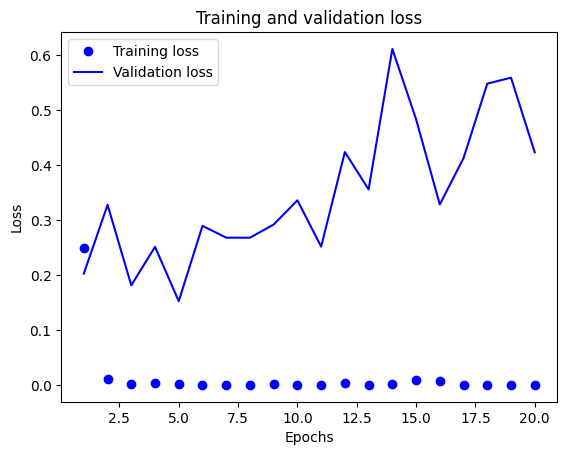

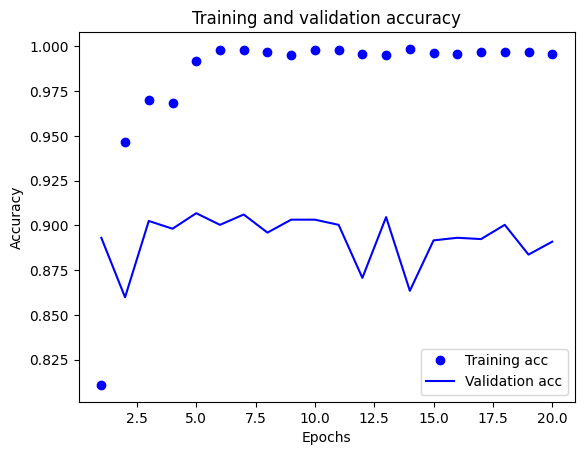

+---------------------+----------+-----------+------------+------------+------------+-------------+-------------+-------------+----------+-------------+-------------+-----------+-------------+-------------+------------+------------+-------------+-------------+-------------+-------------+
|                     |        1 |         2 |          3 |          4 |          5 |           6 |           7 |           8 |        9 |          10 |          11 |        12 |          13 |          14 |         15 |         16 |          17 |          18 |          19 |          20 |
+=====================+==========+===========+============+============+============+=============+=============+=============+==========+=============+=============+===========+=============+=============+============+============+=============+=============+=============+=============+
| training accuracy   | 0.810874 | 0.946712  | 0.970195   | 0.968208   | 0.991871   | 0.998013    | 0.997832    | 0.996568    | 0.994

In [8]:
model=finetune(20, dataloader, model, loss_fn, optimizer)

Our training is done! As can be seen from the result, the classifier can achieve an accuracy of around 90% on the validation dataset. This shows how BERT can also be used in sentiment analysis area: it can help us determine the sentiment expressed in a given piece of text, and achieve good testing results.

Now let's use some sample data to do testing:

In [15]:
class BertDataset_test(Dataset):
    def __init__(self, tokenizer,max_length):
        super(BertDataset_test, self).__init__()
        #self.root_dir=root_dir
        self.train_csv=pd.read_csv('testing_data.csv')
        print(self.train_csv.head(10))
        self.tokenizer=tokenizer
        self.target=self.train_csv.iloc[:,1]
        self.max_length=max_length
        print("max size of each tokenized data is: "+str(max_length)+"\n")
        
    def __len__(self):
        return len(self.train_csv)
    
    def __getitem__(self, index):
        
        text1 = self.train_csv.iloc[index,0]
        
        inputs = self.tokenizer.encode_plus(
            text1 ,
            None,
            pad_to_max_length=True,
            add_special_tokens=True,
            return_attention_mask=True,
            max_length=self.max_length,
        )
        ids = inputs["input_ids"]
        token_type_ids = inputs["token_type_ids"]
        mask = inputs["attention_mask"]

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'target': torch.tensor(self.train_csv.iloc[index, 1], dtype=torch.long)
            }
dataset_sample_test=BertDataset_test(tokenizer, max_length=100)

dataloader_sample_test=DataLoader(dataset=dataset_sample_test,batch_size=32)

sample_acc, sample_loss, sample_pred=model_testing(dataloader_sample_test,model, loss_fn)

print(sample_pred)

                                                   0  1
0  "Inception" - Christopher Nolan's mind-bending...  1
1  "The Shawshank Redemption" - This emotionally ...  1
2  "La La Land" - This modern musical is a deligh...  1
3  "Up" - Pixar's animated gem combines heartfelt...  1
4  "The Dark Knight" - Christopher Nolan's grippi...  1
5  "The Last Airbender" - M. Night Shyamalan's ad...  0
6  "Transformers: Revenge of the Fallen" - This s...  0
7  "Cats" - This ill-conceived musical adaptation...  0
8  "Suicide Squad" - Despite a promising premise ...  0
9  "The Emoji Movie" - This animated feature atte...  0
max size of each tokenized data is: 100



  0%|                                                     | 0/1 [00:00<?, ?it/s]/Users/susieli/anaconda3/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:2377: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
                                                                                

The current model is tested on 10 testing data items.
Accuracy after training this epoch in testing data is: 1.0
Loss after training this epoch in testing data is: 0.00020647705241572112
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]


References:
Bansal, L. (2021, Sep 18). Fine-Tuning BERT for Text Classification in PyTorch [Blog post]. Retrieved from https://luv-bansal.medium.com/fine-tuning-bert-for-text-classification-in-pytorch-503d97342db2
Alammar, J. (2019, Nov 26). A Visual Guide to Using BERT for the First Time [Web article]. Retrieved from http://jalammar.github.io/a-visual-guide-to-using-bert-for-the-first-time/